### Purpose:

### Dependancies:

In [1529]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy.stats as st
from typing import Tuple, List, Dict, Optional
from scipy.stats import pearsonr
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)

### Functions:

In [1530]:
def calc_bowley_skew(df_col: pd.Series) -> Tuple[float, float]:
    """
    Calculate Bowley's coefficient of skewness for a pandas DataFrame column.

    Args:
        df_col (pandas.Series): A pandas DataFrame column.

    Returns:
        float: Bowley's coefficient of skewness.

    Example usage:
        data = {'percent_human': [10, 20, 30, 40, 50, 60, 70]}
        df = pd.DataFrame(data)

        bowley_skew = calc_bowley_skew(df['percent_human'])
        print(bowley_skew)
    """

    if not np.issubdtype(df_col.dtype, np.number):
        raise TypeError("Input column must contain numeric data.")
    
    if df_col.isnull().values.any():
        raise ValueError("Input column contains missing values.")

    q1 = df_col.quantile(0.25)
    q2 = df_col.quantile(0.5)
    q3 = df_col.quantile(0.75)

    bowley_skewness = round((((q3 - q2) - (q2 - q1))) / (q3 - q1), 2)

    return bowley_skewness

In [1531]:
def multiplot(df: pd.DataFrame, fig_name: str = '', col_y: str = None, sd: int = 1, dark_mode: bool = False) -> None:
    """
    Generate a set of 4 plots to visualize the relationship between two variables in a DataFrame.

    Args:
    df (DataFrame): df containing the data
    fig_name (str): Contains the name of the figure, used in titles and save file (optional)
    filter_col (str): Name of the column on which to filter (optional)
    filter_min (float): Minimum value for the filter_col (optional)
    filter_max (float): Maximum value for the filter_col (optional)
    dark_mode(bool): Toggles darkmode True = dark mode on
    """

    if fig_name == '':
        fig_name = 'Figure X'
    
# colors for dark mode and light mode 
    if dark_mode:
        facecolor = '0.1'
        #color1 = 'white'
        #color2 = 'green'
        #color1 = '#55aeff' # borders and text: Originality.AI light blue
        color1 = '#B3B3B3' # borders and text: med grey
        #color2 = '#051D40' # data: Originality.AI dark blue
        color2 = 'green' # data:
        color3 = 'red'
    else:
        facecolor = 'white'
        color1 = '#051D40' # borders and text: Originality.AI dark blue
        color2 = '#55aeff' # data: Originality.AI light blue
        color3 = '#FF5757' # highlights: Originality.AI orange

# define subplots
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), facecolor=facecolor)
    
# apply main title
    main_title = f'{fig_name}: Attributes of {col_y} With Respect To Rank: ({len(df)} values)'
    fig.suptitle(main_title, fontsize=20, fontweight='bold', y=.98, color=color1)
    
# SubFig a: Q-Q plot [0, 0]
    osm, osr = st.probplot(df[col_y], dist='norm', fit=False)
    sorted_col_y = np.sort(df[col_y])
    axs[0, 0].scatter(osm, sorted_col_y, color=color2)

    # Add the reference line with red color
    slope, intercept, _, _, _ = st.linregress(osm, sorted_col_y)
    x_values = np.array(axs[0, 0].get_xlim())
    y_values = intercept + slope * x_values
    axs[0, 0].plot(x_values, y_values, color=color3)

    # Set the titles and labels
    axs[0, 0].set_title(f'{fig_name}a: Q-Q Plot of {col_y}')
    axs[0, 0].set_xlabel('Theoretical Quantiles')
    axs[0, 0].set_ylabel('Sample Quantiles')
    #axs[0, 0].text(0.03, 0.96, 'Data is not normally distributed.', transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='top', color=color1)

    
# SubFig b: Histogram [0, 1]
    mean_val = df[col_y].mean()
    sd_val = df[col_y].std()*sd
    bins = np.arange(df[col_y].min()-0.5, df[col_y].max()+1.5, 1)
    sns.histplot(data=df[col_y], kde=False, bins=bins, color=color2, ax=axs[0, 1], edgecolor=color1)
    #sns.histplot(data=df[col_y], kde=False, binwidth=1, color=color2, ax=axs[0, 1], edgecolor=color1)
    axs[0, 1].set_title(f'{fig_name}b: Histogram of {col_y}')
    axs[0, 1].set_xlabel(col_y)
    axs[0, 1].set_ylabel('Count')
    max_y = df[col_y].max()
    axs[0, 1].set_xlim(-0.5, max_y + 0.5)
    axs[0, 1].set_ylim(0, None)
    axs[0, 1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    #bowley_skew = calc_bowley_skew(df[col_y])
    #axs[0, 1].text(0.01, 0.87, f'Bowley Skewness: {bowley_skew}', transform=axs[0, 1].transAxes, fontsize=12, verticalalignment='top', color=color1)
    
    if sd:
        # Add vertical lines for the mean and SD to the second subplot
        axs[0, 1].axvline(x=mean_val, color=color3)
        axs[0, 1].axvline(x=mean_val + sd_val, color=color3, linestyle='--')
        axs[0, 1].axvline(x=mean_val - sd_val, color=color3, linestyle='--')

        # Add a legend to the plot
        axs[0, 1].legend([f"Mean {mean_val:.1f}", f"SD ±{sd_val:.1f}"], loc='upper left', facecolor=facecolor, edgecolor=color1)

        for text in axs[0, 1].legend_.get_texts():
            text.set_color(color1)

# SubFig c: Violin plot [1, 0]
    grouped_data = df.groupby("rank")[col_y].apply(list)

    # Create custom violin plots using sns.violinplot
    custom_palette = {i: color2 for i in range(1, len(df['rank'].unique()) + 1)}
    sns.violinplot(ax=axs[1, 0], data=df, x="rank", y=col_y, scale="count", inner=None, palette=custom_palette, cut=0, linewidth=.9)

    # Set edge color for violin plots
    for violin in axs[1, 0].collections:
        violin.set_edgecolor(color1)

    # Custom box plots
    for rank, values in grouped_data.items():
        box = axs[1, 0].boxplot(values, positions=[rank - 1], widths=0.1, patch_artist=True, sym='')
        for patch in box['boxes']:
            patch.set_facecolor(color1)
            patch.set_edgecolor(color1)

    # Plot median markers
    median_markers = df.groupby('rank')[col_y].median()
    sns.scatterplot(ax=axs[1, 0], x=median_markers.index-1, y=median_markers.values, marker='o', s=20, color=color3, edgecolor=color1, zorder=100)

    # Plot mean lines
    for i, mean in enumerate(df.groupby("rank")[col_y].mean()):
        axs[1, 0].hlines(mean, i-0.25, i+0.25, linewidth=1, color=color1, zorder=100)

    axs[1, 0].set_title(f'{fig_name}c: {col_y} vs. Rank')
    axs[1, 0].set_xlabel('Rank')
    axs[1, 0].set_ylabel(col_y)


# SubFig d: Scatter plot [1, 1]
    grouped_data = df.groupby('rank')
    mean_col_y = grouped_data[col_y].mean().reset_index()
    
    reg2 = sns.regplot(ax=axs[1, 1], data=mean_col_y, x='rank', y=col_y, color=color3, scatter=False, line_kws={'linestyle':'--'}, ci=None, label='Best fit line')
    sns.scatterplot(ax=axs[1, 1], data=mean_col_y, x='rank', y=col_y,  color=color2, edgecolor=color1, zorder=10)
    sns.regplot(ax=axs[1, 1], data=mean_col_y, x='rank', y=col_y, color=color2, scatter=False, line_kws={'linestyle':''})

    axs[1, 1].set_title(f'{fig_name}d: Mean {col_y} vs. Rank')
    axs[1, 1].set_xlabel('Rank')
    axs[1, 1].set_ylabel(f'Mean {col_y}')
    axs[1, 1].set_xticks(np.arange(1, 21))
    handles, labels = reg2.get_legend_handles_labels()
    legend = axs[1, 1].legend(handles=handles, labels=labels, facecolor=facecolor, labelcolor=color1)
    legend.get_frame().set_edgecolor(color1)

    sp_corr, sp_pval = st.spearmanr(df['rank'], df[col_y])
    #pb_corr, pb_pval = st.pointbiserialr(df['rank'], df[col_y])
    axs[1, 1].text(0.02, 0.05, f"Spearmann correlation coeficent: {sp_corr:.3g}, p-value: {sp_pval:.3g}", transform=axs[1, 1].transAxes, fontsize=12, verticalalignment='top', color=color1)

# format all graphs
    for ax in axs.flat:
        ax.tick_params(axis='x', labelsize=12, colors=color1)
        ax.tick_params(axis='y', labelsize=12, colors=color1)
        ax.set_xlabel(ax.get_xlabel(), fontdict={'fontsize': 14, 'color': color1})
        ax.set_ylabel(ax.get_ylabel(), fontdict={'fontsize': 14, 'color': color1})
        ax.set_title(ax.get_title(), fontdict={'fontsize': 16, 'color': color1})
        ax.set_facecolor(facecolor)
        for spine in ax.spines.values():
            spine.set_edgecolor(color1)
            #spine.set_linewidth(2)
    
# shrink outer margin of plot
    fig.subplots_adjust(left=0.05, right=0.95, top=.90, bottom=0.05)
    
# compose figure info into filename and save 
    pattern = re.compile(r'\s+')
    fig_name = pattern.sub('_', fig_name)
    file_name = 'figures/' + fig_name + '_a-d.png'
    
    # Create the figures directory if it doesn't exist
    if not os.path.exists('figures'):
        os.makedirs('figures')
        
    fig.savefig(file_name)

    plt.show()

In [1532]:
def make_plot(df, lines=True):
    columns = ['Flesch Score', 'Gunning-Fog Score', 'FORCAST Score',
       'Powers-Sumner-Kearl Score', 'Dale-Chall Score',
       'Automated Readability Score', 'Flesch Grade', 'Coleman Score',
       'Smog Score', 'Spache Score']

    # Color variables
    bg_color = '#333333'
    text_color = 'white'
    border_color = 'white'
    tick_color = 'white'

    # Font size variables
    label_font_size = 12
    title_font_size = 14
    tick_font_size = 10
    legend_font_size = 10

    # Create the grid of subplots
    nrows, ncols = 4, 4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), sharex=True)
    fig.patch.set_facecolor(bg_color)

    # Iterate through the columns and create a plot for each one
    for idx, col in enumerate(columns):
        i, j = np.unravel_index(idx, (nrows, ncols))
        ax = axes[i, j]

        # Calculate correlation coefficient and p-value
        corr_coef, p_value = pearsonr(df['rank'], df[col])

        # Create a scatter plot of the column against 'rank'
        ax.scatter(df['rank'], df[col], label=col)

        # Add lines if lines option is set to True
        if lines:
            ax.plot(df['rank'], df[col], label=col, alpha=0.3)

        # Set axis labels, title, and their colors and font sizes
        ax.set_xlabel('Rank', color=text_color, fontsize=label_font_size)
        ax.set_ylabel('Values', color=text_color, fontsize=label_font_size)
        ax.set_title(f'Rank vs {col}\nCorr Coef: {corr_coef:.2f} | P-value: {p_value:.2e}', color=text_color, fontsize=title_font_size)

        # Set tick and border colors, and tick font size
        ax.tick_params(axis='x', colors=tick_color, labelsize=tick_font_size)
        ax.tick_params(axis='y', colors=tick_color, labelsize=tick_font_size)
        ax.spines['bottom'].set_color(border_color)
        ax.spines['top'].set_color(border_color)
        ax.spines['right'].set_color(border_color)
        ax.spines['left'].set_color(border_color)

        # Set the plot background color
        ax.set_facecolor(bg_color)

        # Add legend with white text, set font size, and set face color
        legend = ax.legend()
        plt.setp(legend.get_texts(), color=text_color, fontsize=legend_font_size)
        legend.get_frame().set_facecolor(bg_color)

    # Remove extra subplots if any
    for idx in range(len(columns), nrows * ncols):
        i, j = np.unravel_index(idx, (nrows, ncols))
        fig.delaxes(axes[i, j])

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [1533]:
def full_plot(df, col_1, col_2):
    # Calculate the Pearson correlation coefficient and p-value
    r, p = pearsonr(df[col_1], df[col_2])

    # Define colors for each type
    colors = {'face_color': '0.1', 'border_color': '#B3B3B3', 'data_color': 'green', 'fit_color': 'red'}

    # Create a subplot with 1 row and 1 column
    fig, ax = plt.subplots(1, 1)

    # Create an xy scatter plot of rank vs the selected column with a confidence interval
    sns.regplot(x=col_1, y=col_2, data=df, ax=ax, scatter_kws={'alpha': 0.15}, color=colors['data_color'], line_kws={'color': colors['fit_color']})

    # Set the x-range to .5 to 20.5
    ax.set_xlim(.5, 20.5)

    # Set the x-ticks to 1 through 20
    ax.set_xticks(np.arange(1, 21))

    # Set the axis labels
    ax.set_xlabel(col_1)
    ax.set_ylabel(col_2)

    # Change the average marker to a small x
    ax.scatter(df.groupby(col_1)[col_2].mean().index, df.groupby('rank')[col_2].mean().values, marker='x', color=colors['border_color'], s=50)

    # Change the best fit line to red
    ax.lines[0].set_color(colors['fit_color'])

    # Add a legend to the plot
    ax.legend(['Best Fit Line', 'Average'])

    # Add the correlation coefficient, p-value, and confidence interval to the title
    title = f"{col_2} (r={r:.4f}, p={p:.4f})"
    ax.set_title(title)

    # Show the plot
    plt.show()

In [1534]:
def single_plot(df, col_x, col_y):

    # Color variables
    bg_color = '#222222'
    text_color = 'white'
    border_color = 'white'
    tick_color = 'white'
    point_color = 'green'
    line_color = 'red'

    # Font size variables
    label_font_size = 12
    title_font_size = 14
    tick_font_size = 10
    legend_font_size = 10

    # Create the grid of subplots
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.patch.set_facecolor(bg_color)

    # Calculate correlation coefficient and p-value
    corr_coef, p_value = st.spearmanr(df[col_x], df[col_y])

    # Create a scatter plot of the column against 'rank'
    scatter = ax.scatter(df[col_x], df[col_y], color=point_color)

    # Add a best fit line
    slope, intercept, r_value, p_value, std_err = st.linregress(df[col_x], df[col_y])
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    line = ax.plot(x_vals, y_vals, color=line_color, label='Best Fit Line')

    # Set axis labels, title, and their colors and font sizes
    ax.set_xlabel(col_x, color=text_color, fontsize=label_font_size)
    ax.set_ylabel(col_y, color=text_color, fontsize=label_font_size)
    ax.set_title(f'{col_x} vs {col_y}\nCorr Coef: {corr_coef:.2f} | P-value: {p_value:.2e}', color=text_color, fontsize=title_font_size)

    # Set tick and border colors, and tick font size
    ax.tick_params(axis='x', colors=tick_color, labelsize=tick_font_size)
    ax.tick_params(axis='y', colors=tick_color, labelsize=tick_font_size)
    ax.spines['bottom'].set_color(border_color)
    ax.spines['top'].set_color(border_color)
    ax.spines['right'].set_color(border_color)
    ax.spines['left'].set_color(border_color)

    # Set the plot background color
    ax.set_facecolor(bg_color)

    # Add legend and set font size and color
    handles, labels = ax.get_legend_handles_labels()
    handles = [line[0]]
    labels = ['Best Fit Line']
    ax.legend(handles=handles, labels=labels, fontsize=legend_font_size, facecolor=bg_color, edgecolor=border_color)
    leg = ax.get_legend()
    for text in leg.get_texts():
        text.set_color(text_color)

    plt.tight_layout()
    plt.show()

In [1535]:
def find_ai_in_range(df: pd.DataFrame, col: str, cut_min: float = 0, cut_max: float = 100) -> None:

    df_lower = df[(df[col] < cut_min)]
    df_middle = df[(df[col] >= cut_min) & (df[col] <= cut_max)]
    df_upper = df[(df[col] > cut_max)]

    count_lower_ai = df_lower[(df_lower['aics'] > 50)].shape[0]
    count_middle_ai = df_middle[(df_middle['aics'] > 50)].shape[0]
    count_upper_ai = df_upper[(df_upper['aics'] > 50)].shape[0]

    count_lower = len(df_lower)
    count_middle = len(df_middle)
    count_upper = len(df_upper)

    if count_lower:
        print(f"For {col} below {cut_min}: {count_lower_ai} of {count_lower}, or {(count_lower_ai / count_lower *100):.1f}% of have AI-CS > 50%")
    else:
        print(f"There are no {col} values below {cut_min}")

    if count_middle:
        print(f"For {col} above {cut_min} and below {cut_max}: {count_middle_ai} of {count_middle}, or {(count_middle_ai / count_middle *100):.1f}% of have AI-CS > 50%")
    else:
        print(f"There are no {col} values above {cut_min} and below {cut_max}")

    if count_upper:
        print(f"For {col} above {cut_max}: {count_upper_ai} of {count_upper}, or {(count_upper_ai / count_upper *100):.1f}% of have AI-CS > 50%")
    else: print(f"There are no {col} values above {cut_max}")

In [1536]:
def avg_aics_by_quartile(df, col):
    """
    Calculates the average 'aics' by quartile of 'col' in the input DataFrame 'df'.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame.
    col (str): Column in the DataFrame to use for quartile grouping.
    
    Returns:
    pandas.DataFrame: DataFrame with the average 'aics' for each quartile of 'col'.
    """
    # Calculate quartiles of 'col'
    quartiles = pd.qcut(df[col], q=4, labels=False)
    
    # Group DataFrame by quartiles and calculate mean 'aics'
    result = df.groupby(quartiles)['aics'].mean().reset_index()
    
    return result

In [1537]:
def avg_aics_within_sd(df, col):
    """
    Calculates the average 'aics' within 1, 2, and 3 standard deviations of 'col' in the input DataFrame 'df'.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame.
    col (str): Column in the DataFrame to use for calculating standard deviation and filtering.
    
    Returns:
    pandas.DataFrame: DataFrame with the average 'aics' for values within 1, 2, and 3 standard deviations of 'col'.
    """
    # Calculate mean and standard deviation of 'col'
    col_mean = df[col].mean()
    col_std = df[col].std()
    
    # Filter DataFrame to only include rows within 3 standard deviations of the mean
    filtered_df = df[(df[col] >= col_mean - 3 * col_std) & (df[col] <= col_mean + 3 * col_std)]
    
    # Calculate mean 'aics' for values within 1, 2, and 3 standard deviations of 'col'
    avg_aics_1sd = filtered_df[(filtered_df[col] >= col_mean - col_std) & (filtered_df[col] <= col_mean + col_std)]['aics'].mean()
    avg_aics_2sd = filtered_df[(filtered_df[col] >= col_mean - 2 * col_std) & (filtered_df[col] <= col_mean + 2 * col_std)]['aics'].mean()
    avg_aics_3sd = filtered_df[(filtered_df[col] >= col_mean - 3 * col_std) & (filtered_df[col] <= col_mean + 3 * col_std)]['aics'].mean()
    
    # Create DataFrame with the results
    result = pd.DataFrame({'sd': [1, 2, 3], 'avg_aics': [avg_aics_1sd, avg_aics_2sd, avg_aics_3sd]})
    
    return result

In [1538]:
def avg_aics_in_out_of_sd(df, col, sd=1):
    """
    Calculates the average 'aics' within and outside a specified number of 
    standard deviations of 'col' in the input DataFrame 'df'.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame.
    col (str): Column in the DataFrame to use for standard deviation grouping.
    sd (int): Number of standard deviations to use for grouping. Default is 1.
    
    Returns:
    Tuple of two pandas.DataFrames: DataFrames with the average 'aics' 
    within and outside the specified number of standard deviations of 'col'.
    """
    # Calculate the mean and standard deviation of 'col'
    col_mean = df[col].mean()
    col_std = df[col].std()
    
    # Group DataFrame by whether each value of 'col' is within the specified number of 
    # standard deviations of the mean or not, and calculate mean 'aics' for each group
    df_within_sd = df.loc[(df[col] >= col_mean - sd * col_std) & (df[col] <= col_mean + sd * col_std)]
    df_outside_sd = pd.concat([df[df[col] < col_mean - sd * col_std], df[df[col] > col_mean + sd * col_std]])
    result_within_sd = pd.DataFrame({'avg_aics_within_{}sd'.format(sd): [df_within_sd['aics'].mean()]})
    result_outside_sd = pd.DataFrame({'avg_aics_outside_{}sd'.format(sd): [df_outside_sd['aics'].mean()]})
    
    return result_within_sd, result_outside_sd

In [1539]:
def plot_aics_vs_deviation(df, col):
    # Calculate the deviation of 'col_name' from its mean
    col_mean = df[col].mean()
    df['col_deviation'] = df[col] - col_mean

    # Plot 'aics' vs 'col_deviation'
    plt.scatter(df['col_deviation'], df['aics'])
    plt.xlabel(f"Deviation of {col} from its mean")
    plt.ylabel('AI-CS')
    plt.title(f"AI-CS vs. {col}")
    plt.show()

In [1540]:
def plot_aics_above_50pct_by_sd(df, col_name):
    # Calculate the mean and standard deviation of the specified column
    col_mean = df[col_name].mean()
    col_std = df[col_name].std()

    # Define the cutoff values for the standard deviations
    cutoffs = [col_mean - i*col_std for i in range(1, 11)][::-1] + [col_mean + i*col_std for i in range(11)]

    # Count the number of 'aics' that are above 50% for each range of standard deviations
    aics_counts = []
    for i in range(len(cutoffs)-1):
        df_range = df.loc[(df[col_name] >= cutoffs[i]) & (df[col_name] < cutoffs[i+1])]
        aics_counts.append(df_range[df_range['aics'] > df_range['aics'].median()].shape[0])

    # Plot the histogram
    plt.bar(range(-10, 11), aics_counts)
    plt.xlabel(f"Standard deviation from the mean of {col_name}")
    plt.ylabel('Count of "aics" above 50%')
    plt.title('Histogram of "aics" above 50% by standard deviation of {}'.format(col_name))
    plt.show()

In [1541]:
def plot_sd_vs_average_aics(df, col, num_intervals=10):
    # Calculate the mean and standard deviation of the specified column
    mean_col = df[col].mean()
    sd_col = df[col].std()
    
    # Calculate the interval for grouping
    interval = sd_col / num_intervals
    
    # Create lists to store the standard deviation intervals and average AICs
    sd_intervals = []
    avg_aics = []

    for i in range(-num_intervals, num_intervals + 1):
        # Calculate the lower and upper bounds for each standard deviation interval
        lower_bound = mean_col + i * interval
        upper_bound = mean_col + (i + 1) * interval
        
        # Calculate the average AICs for each standard deviation interval
        if i < 0:
            avg_aic = df.loc[df[col] <= upper_bound, 'aics'].mean()
        else:
            avg_aic = df.loc[df[col] >= lower_bound, 'aics'].mean()
        
        # Append the standard deviation interval and the corresponding average AICs to the lists
        sd_intervals.append(i)
        avg_aics.append(avg_aic)

    # Create a DataFrame from the lists
    plot_data = pd.DataFrame({'sd_intervals': sd_intervals, 'avg_aics': avg_aics})

    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='sd_intervals', y='avg_aics', data=plot_data, marker='o')

    # Set plot title, labels, and grid
    plt.title(f"Standard Deviation Intervals of {col} vs. Average AICs")
    plt.xlabel(f'Standard Deviation Intervals of {col}')
    plt.ylabel('Average AICs')
    plt.grid()

    # Show the plot
    plt.show()

### Code Execution:

In [1542]:
df = pd.read_csv('data/combined_final.csv')
df.tail(1)
df = df.drop(columns={'text', 'link'})
df.head(1)
#df = df.drop(columns={'hcs', 'aics'})

,smog,cole,auto,dale,pows,forc,spac,gunn,fleG2,fleS,rank,word_count,hcs,aics
0,12.0,12.0,12.0,10.0,16.2,16.3,5.0,13.2,12.0,23.5,15,200.0,89.878726,10.121275


In [1543]:
df.columns

Index(['smog', 'cole', 'auto', 'dale', 'pows', 'forc', 'spac', 'gunn', 'fleG2',
       'fleS', 'rank', 'word_count', 'hcs', 'aics'],
      dtype='object')

In [1544]:
len(df)

13582

In [1545]:
rename_dict = {'smog': 'Smog Index', 'cole': 'Coleman-Liau Index', 'auto': 'Automated Readability Index', 'dale': 'Dale-Chall Index', 'pows': 'Powers-Sumner-Kearl Index', 'forc': 'FORCAST Grade', 'spac': 'Spache Readability Grade', 'gunn': 'Gunning-Fog Index', 'fleG2': 'Flesch-Kincaid Grade', 'fleS': 'Flesch Reading Ease Index'}
df = df.rename(columns=rename_dict)

In [1546]:
new_order = ['rank', 'Flesch Reading Ease Index', 'Gunning-Fog Index', 'FORCAST Grade', 'Dale-Chall Index', 'Powers-Sumner-Kearl Index','Automated Readability Index', 'Flesch-Kincaid Grade', 'Coleman-Liau Index', 'Smog Index', 'Spache Readability Grade', 'word_count', 'aics', 'hcs']
df = df.reindex(columns=new_order)

In [1547]:
df.columns

Index(['rank', 'Flesch Reading Ease Index', 'Gunning-Fog Index',
       'FORCAST Grade', 'Dale-Chall Index', 'Powers-Sumner-Kearl Index',
       'Automated Readability Index', 'Flesch-Kincaid Grade',
       'Coleman-Liau Index', 'Smog Index', 'Spache Readability Grade',
       'word_count', 'aics', 'hcs'],
      dtype='object')

In [1548]:
average_word_count = df[df['Flesch Reading Ease Index'] == 0]['word_count'].mean()
print(f"The average word count for rows with Flesch Score equal to 0 is: {average_word_count}")

The average word count for rows with Flesch Score equal to 0 is: 2153.064705882353


In [1549]:
def standard_scaling(df, col):
    mean_value = df[col].mean()
    std_dev = df[col].std()
    df[col] = (df[col] - mean_value) / std_dev
    return df

# col = 'Flesch Reading Ease Index'
# df_1= [(df[col] > 0.1) & (df[col] < 99.9)]
# df_in = df_1[['Flesch Reading Ease Index', 'rank']]

# normalized_df_standard = standard_scaling(df_in.copy(), 'Flesch Reading Ease Index')
# print("Standard Scaling:\n", normalized_df_standard)

In [1550]:
# col = 'Flesch Reading Ease Index'
# df_mod = normalized_df_standard
# multiplot(df_mod, fig_name = 'Figure 1', col_y = col, sd=1, dark_mode = True)

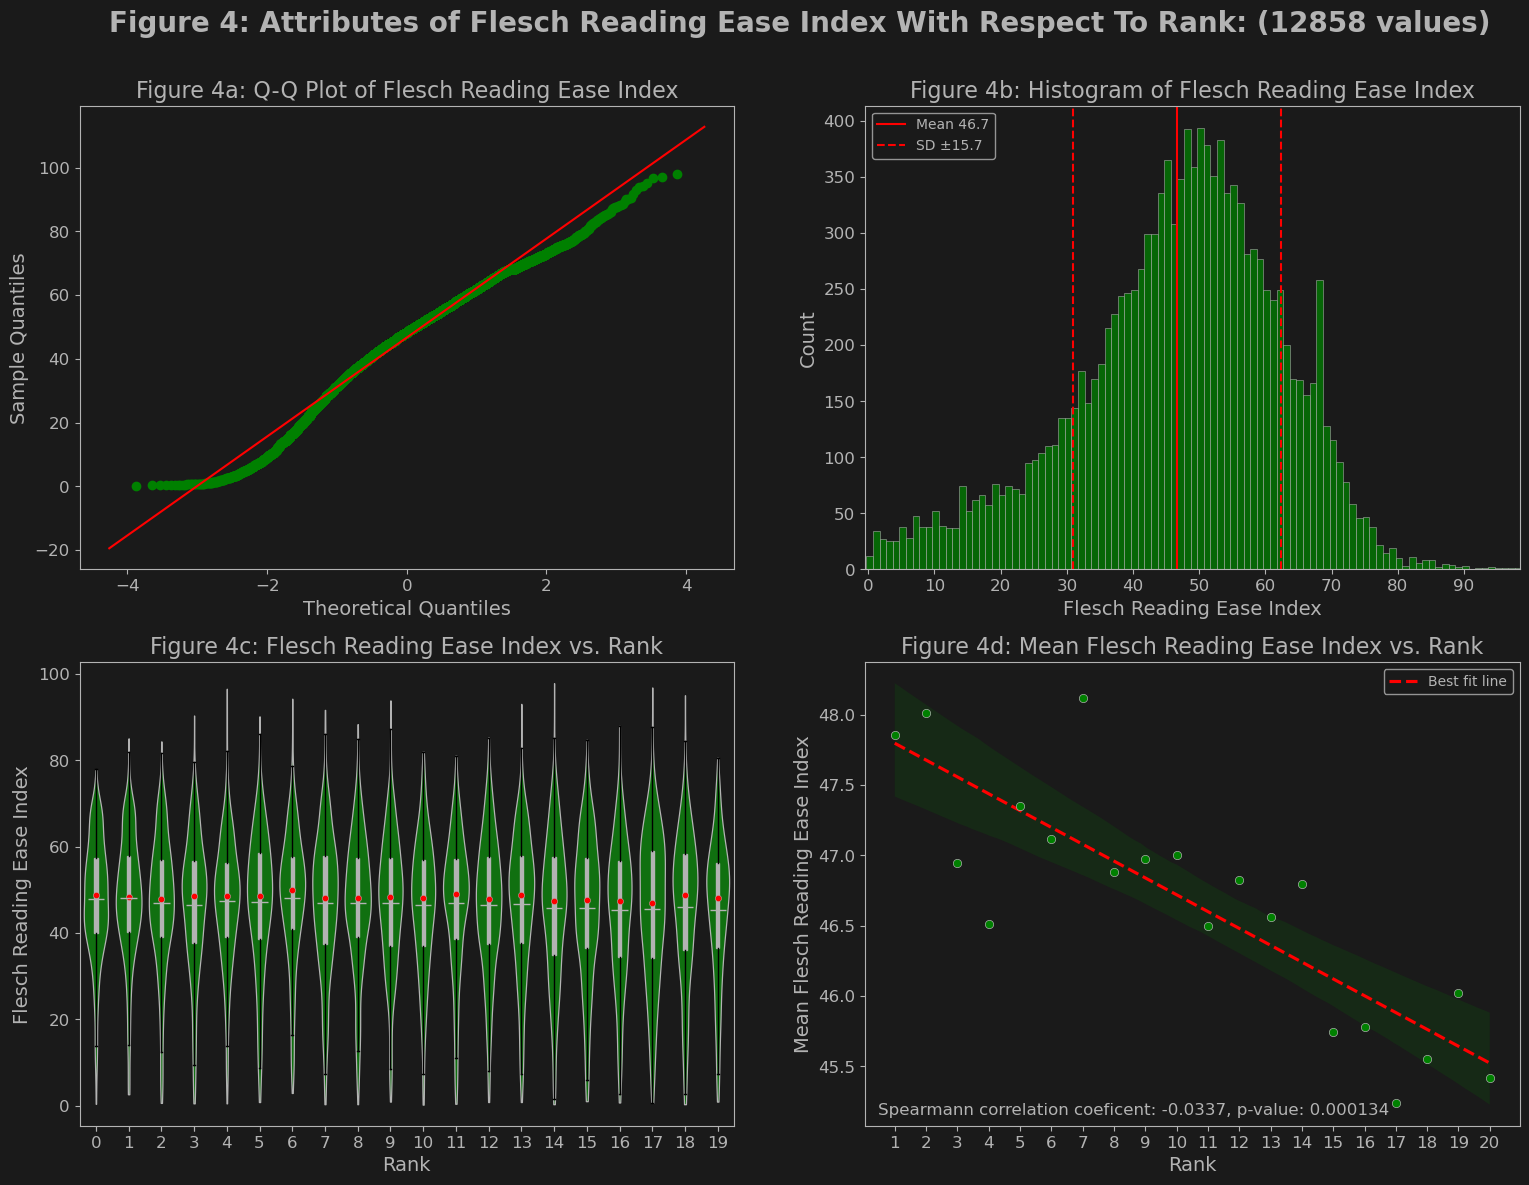

In [1551]:
col = 'Flesch Reading Ease Index'
df_mod = df[(df[col] > 0.1) & (df[col] < 99.9)]
#df_mod = standard_scaling(df_mod, col).copy()
multiplot(df_mod, fig_name = 'Figure 4', col_y = col, sd=1, dark_mode = True)

In [1552]:
find_ai_in_range(df, col='Flesch Reading Ease Index', cut_min=0.1, cut_max= 99.9)

For Flesch Reading Ease Index below 0.1: 147 of 680, or 21.6% of have AI-CS > 50%
For Flesch Reading Ease Index above 0.1 and below 99.9: 1079 of 12862, or 8.4% of have AI-CS > 50%
For Flesch Reading Ease Index above 99.9: 13 of 40, or 32.5% of have AI-CS > 50%


In [1553]:
col = 'Flesch Reading Ease Index'
avg_aics_within_sd(df, col)

,sd,avg_aics
0,1,13.450842
1,2,14.302974
2,3,15.094324


In [1554]:
col = 'Flesch Reading Ease Index'
avg_aics_in_out_of_sd(df, col, sd=2)

(   avg_aics_within_2sd
 0            14.302974,
    avg_aics_outside_2sd
 0             25.051083)

In [1555]:
# even with outliers removed
col = 'Flesch Reading Ease Index'
df_mod = df[(df[col] > 0.1) & (df[col] < 99.9)]
avg_aics_in_out_of_sd(df_mod, col, sd=3)

(   avg_aics_within_3sd
 0            14.524959,
    avg_aics_outside_3sd
 0             30.904691)

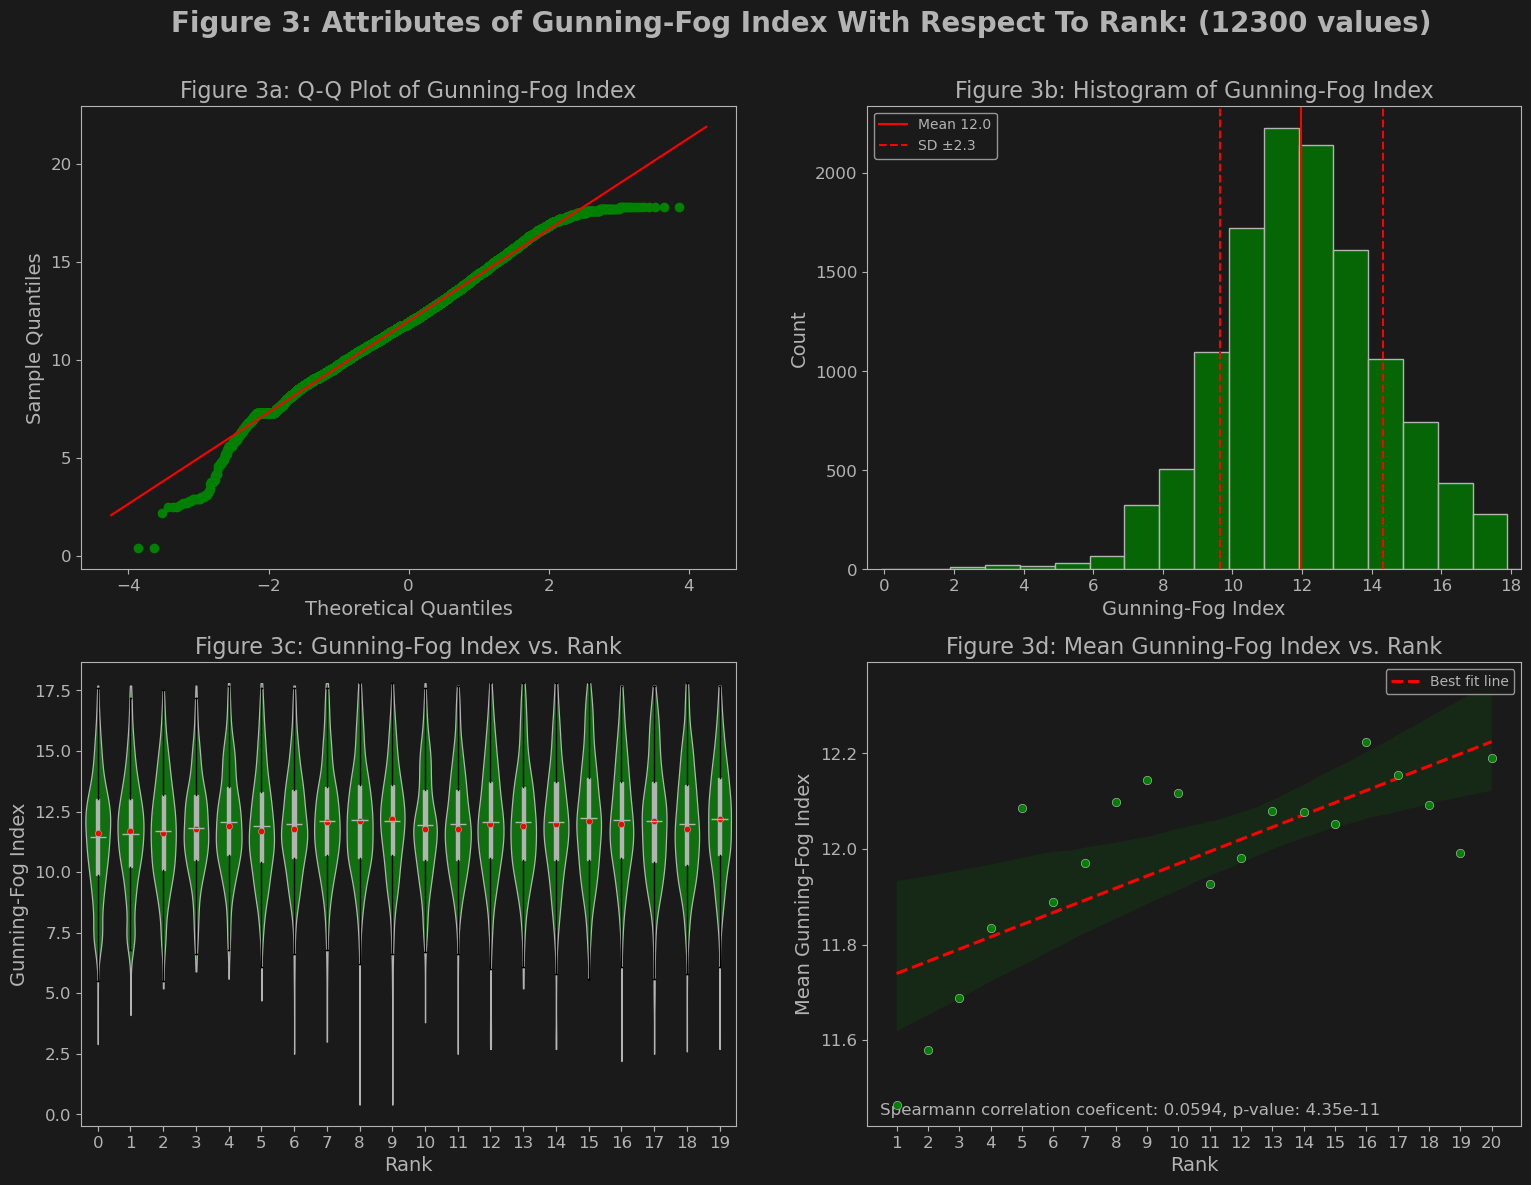

In [1556]:
col = 'Gunning-Fog Index'
df_mod = df[(df[col] > 0) & (df[col] < 17.9)]
multiplot(df_mod, fig_name = 'Figure 3', col_y = col, sd=1, dark_mode = True)

In [1557]:
col = 'Gunning-Fog Index'
avg_aics_within_sd(df, col)

,sd,avg_aics
0,1,13.055621
1,2,13.808812
2,3,15.031998


In [1558]:
col = 'Gunning-Fog Index'
avg_aics_in_out_of_sd(df, col, sd=3)

(   avg_aics_within_3sd
 0            15.031998,
    avg_aics_outside_3sd
 0             45.264258)

In [1559]:
# even with outliers removed
col = 'Gunning-Fog Index'
df_mod = df[(df[col] > 6) & (df[col] < 18)]
avg_aics_in_out_of_sd(df_mod, col, sd=2)

(   avg_aics_within_2sd
 0            13.461671,
    avg_aics_outside_2sd
 0             18.732789)

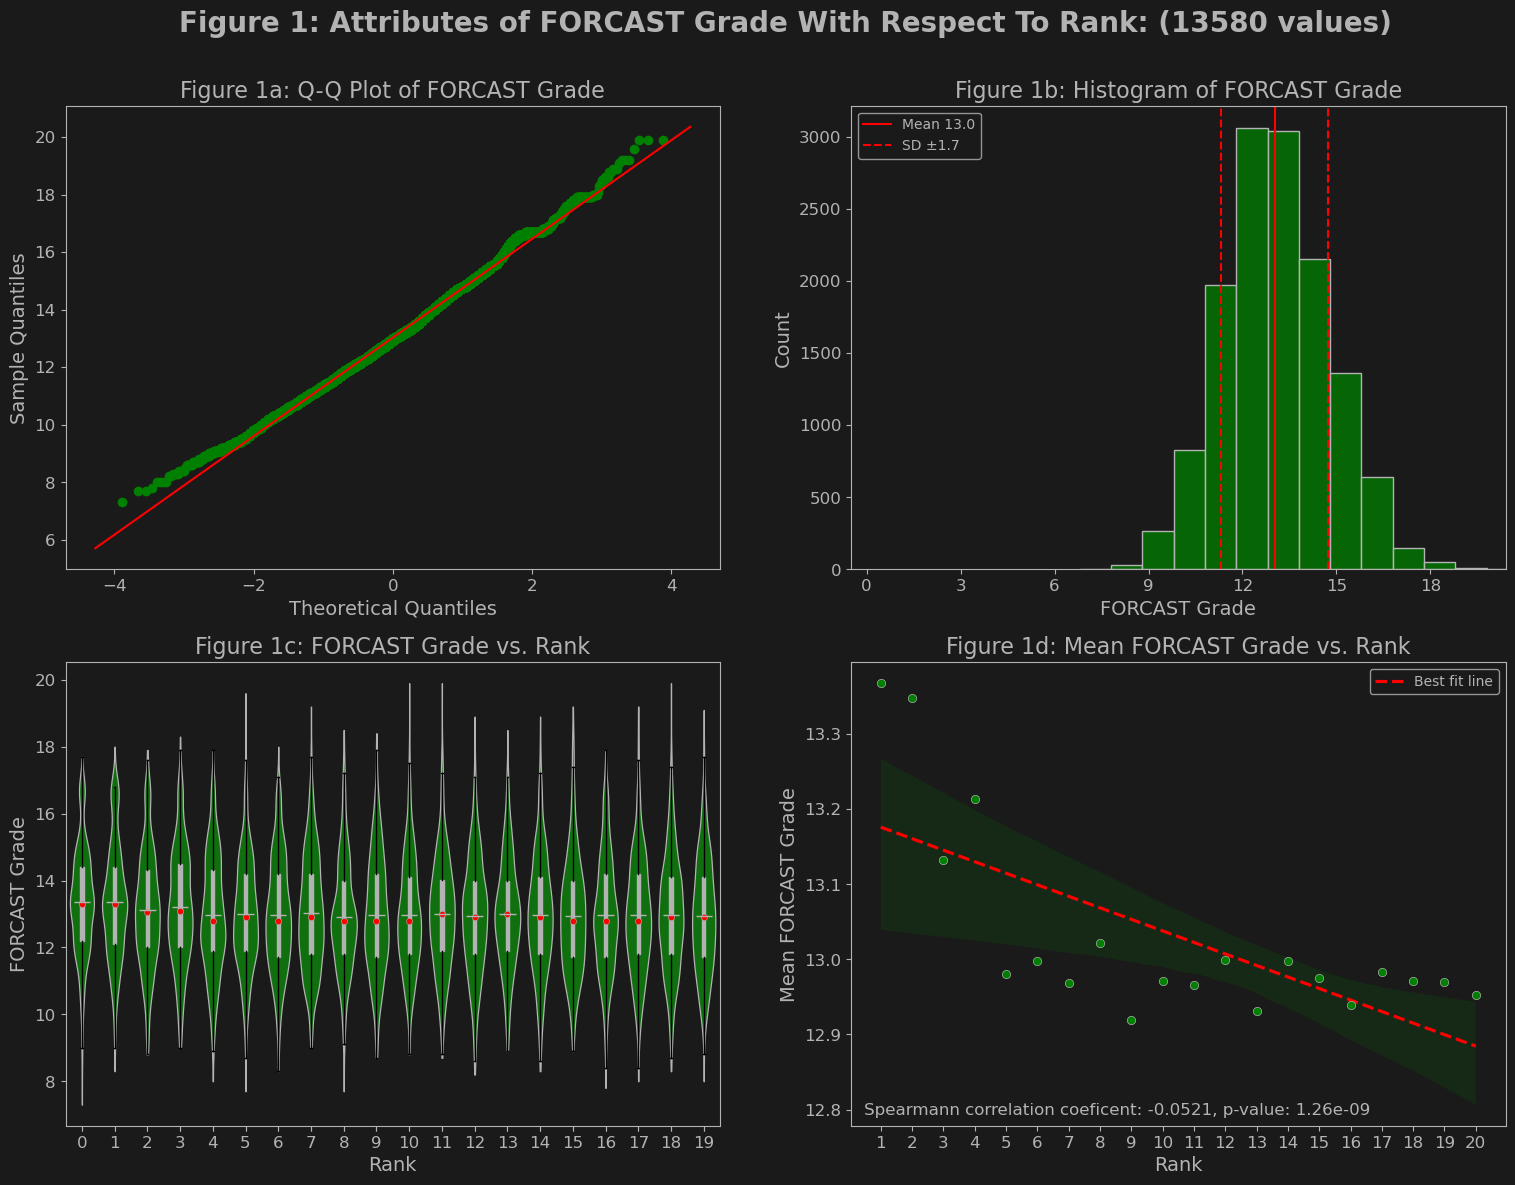

In [1560]:
col = 'FORCAST Grade'
fig = 'Figure 1'
df_mod = df[(df[col] > 0) & (df[col] < 20)]
multiplot(df_mod, fig_name=fig, col_y=col, sd=1, dark_mode = True)

In [1561]:
find_ai_in_range(df, col='FORCAST Grade', cut_min=8, cut_max= 18)

For FORCAST Grade below 8: 3 of 4, or 75.0% of have AI-CS > 50%
For FORCAST Grade above 8 and below 18: 1230 of 13554, or 9.1% of have AI-CS > 50%
For FORCAST Grade above 18: 6 of 24, or 25.0% of have AI-CS > 50%


In [1562]:
col = 'FORCAST Grade'
avg_aics_within_sd(df, col)

,sd,avg_aics
0,1,15.186963
1,2,15.053739
2,3,15.071544


In [1563]:
col = 'FORCAST Grade'
avg_aics_in_out_of_sd(df, col, sd=3)

(   avg_aics_within_3sd
 0            15.071544,
    avg_aics_outside_3sd
 0             26.530835)

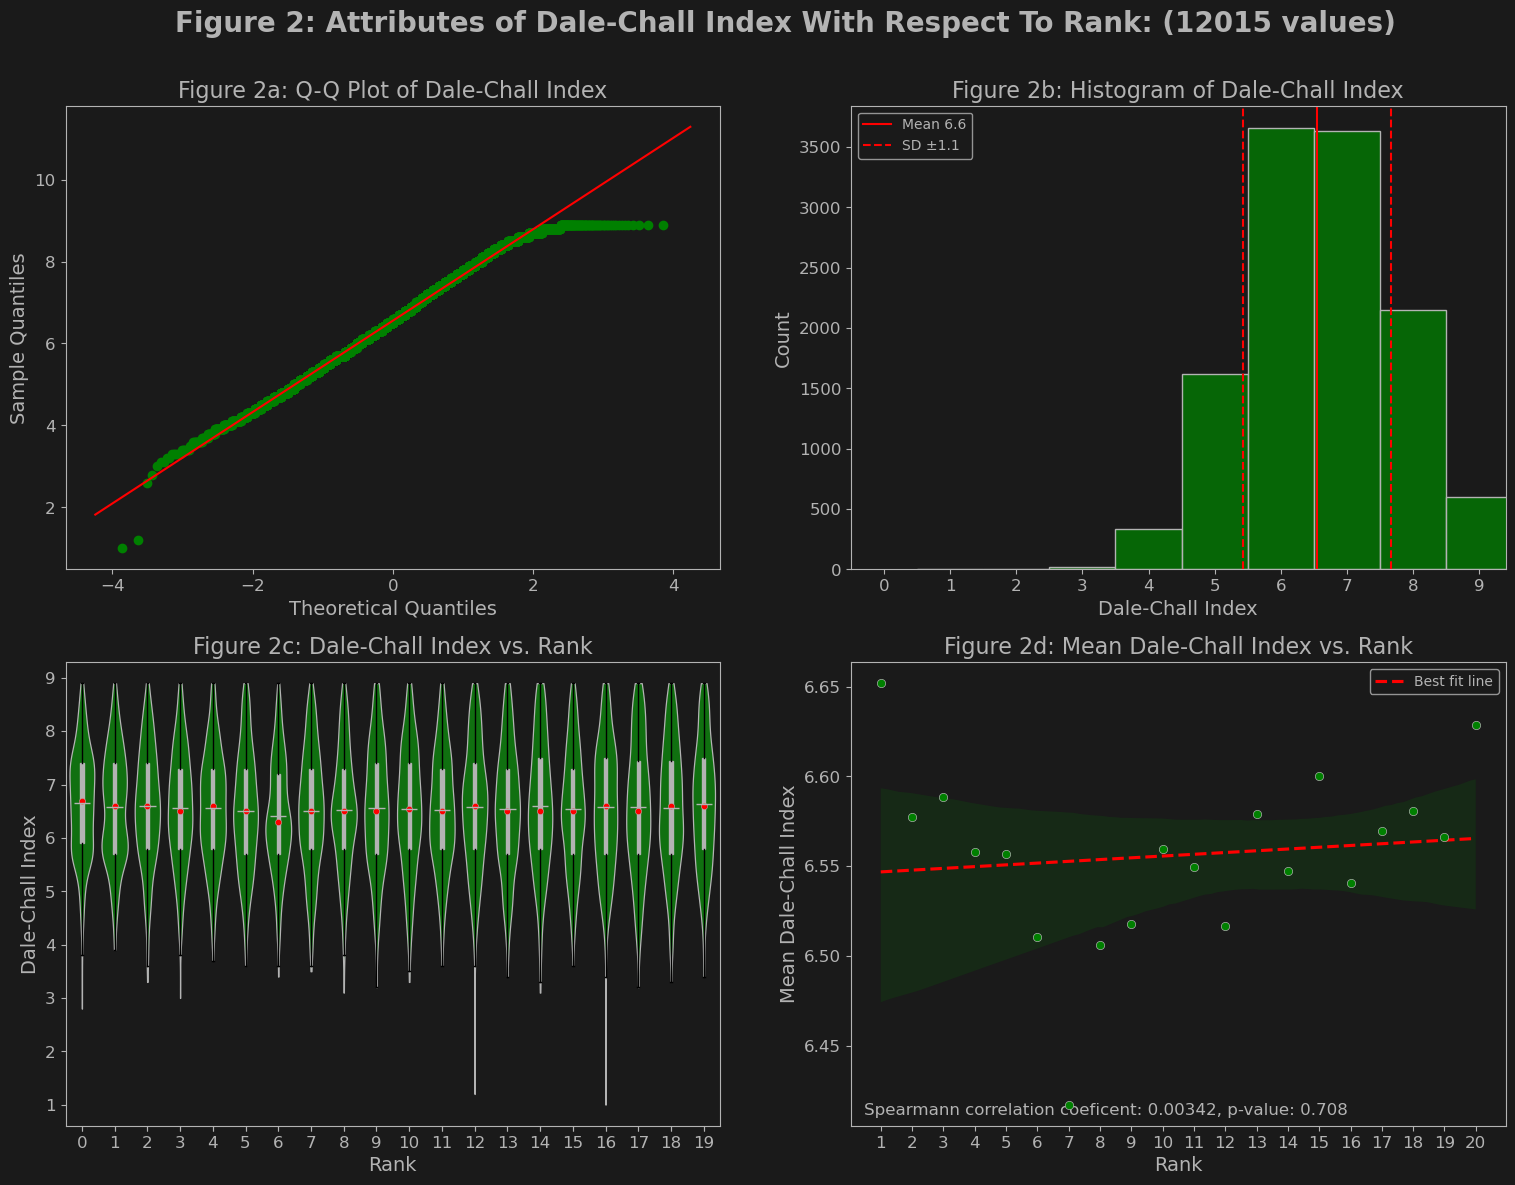

In [1564]:
col = 'Dale-Chall Index'
df_mod = df[(df[col] > 0) & (df[col] < 9)]
multiplot(df_mod, fig_name = 'Figure 2', col_y = col, sd=1, dark_mode = True)

In [1565]:
find_ai_in_range(df, col='Dale-Chall Index', cut_min=4, cut_max= 9)

For Dale-Chall Index below 4: 16 of 98, or 16.3% of have AI-CS > 50%
For Dale-Chall Index above 4 and below 9: 841 of 12000, or 7.0% of have AI-CS > 50%
For Dale-Chall Index above 9: 382 of 1484, or 25.7% of have AI-CS > 50%


In [1566]:
col = 'Dale-Chall Index'
avg_aics_within_sd(df, col)

,sd,avg_aics
0,1,13.720808
1,2,13.963896
2,3,15.094841


In [1567]:
col = 'Dale-Chall Index'
avg_aics_in_out_of_sd(df, col, sd=2)

(   avg_aics_within_2sd
 0            13.963896,
    avg_aics_outside_2sd
 0             29.332734)

In [1568]:
# even with outliers removed
col = 'Dale-Chall Index'
df_mod = df[(df[col] > 4) & (df[col] < 9)]
avg_aics_in_out_of_sd(df_mod, col, sd=1)

(   avg_aics_within_1sd
 0             13.32178,
    avg_aics_outside_1sd
 0             14.196425)

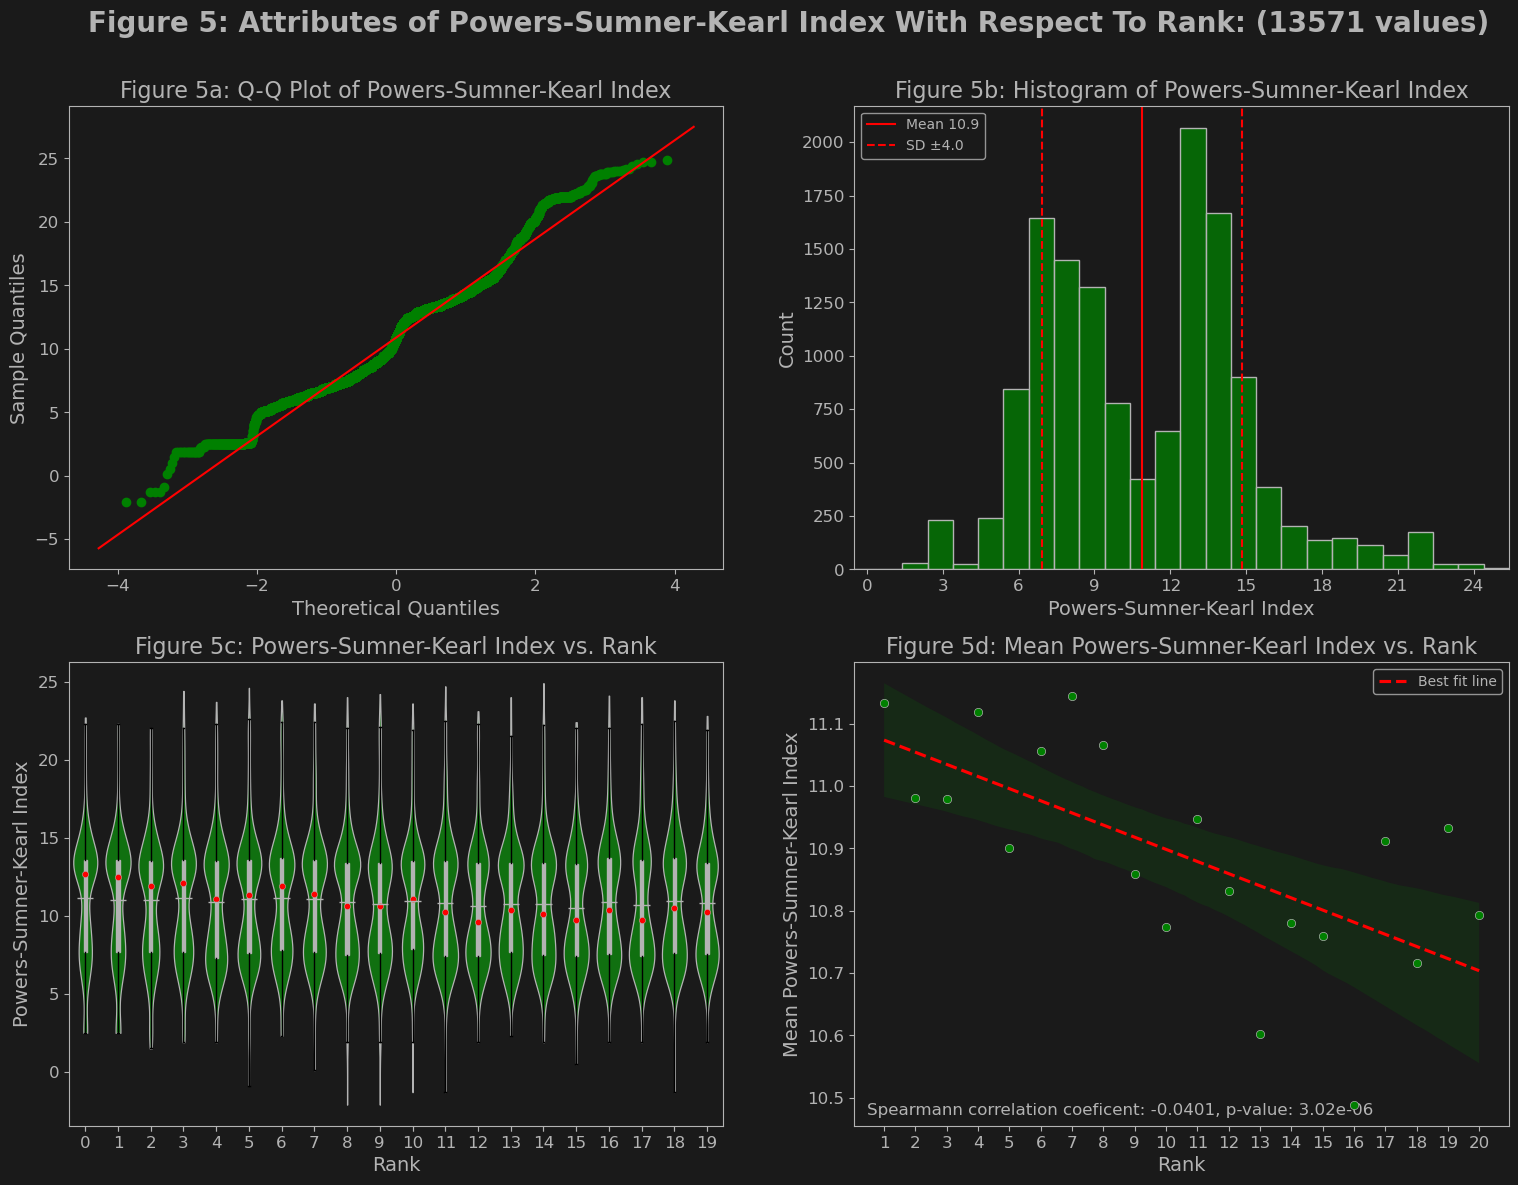

In [1569]:
col = 'Powers-Sumner-Kearl Index'
df_mod = df[df[col] < 25]
multiplot(df_mod, fig_name = 'Figure 5', col_y = col, sd=1, dark_mode = True)

In [1570]:
find_ai_in_range(df, col='Powers-Sumner-Kearl Index', cut_min=5, cut_max= 16)

For Powers-Sumner-Kearl Index below 5: 37 of 351, or 10.5% of have AI-CS > 50%
For Powers-Sumner-Kearl Index above 5 and below 16: 1152 of 12257, or 9.4% of have AI-CS > 50%
For Powers-Sumner-Kearl Index above 16: 50 of 974, or 5.1% of have AI-CS > 50%


In [1571]:
col = 'Powers-Sumner-Kearl Index'
avg_aics_within_sd(df, col)

,sd,avg_aics
0,1,15.511617
1,2,15.238291
2,3,15.132173


In [1572]:
col = 'Powers-Sumner-Kearl Index'
avg_aics_in_out_of_sd(df, col, sd=3)

(   avg_aics_within_3sd
 0            15.132173,
    avg_aics_outside_3sd
 0              5.052334)

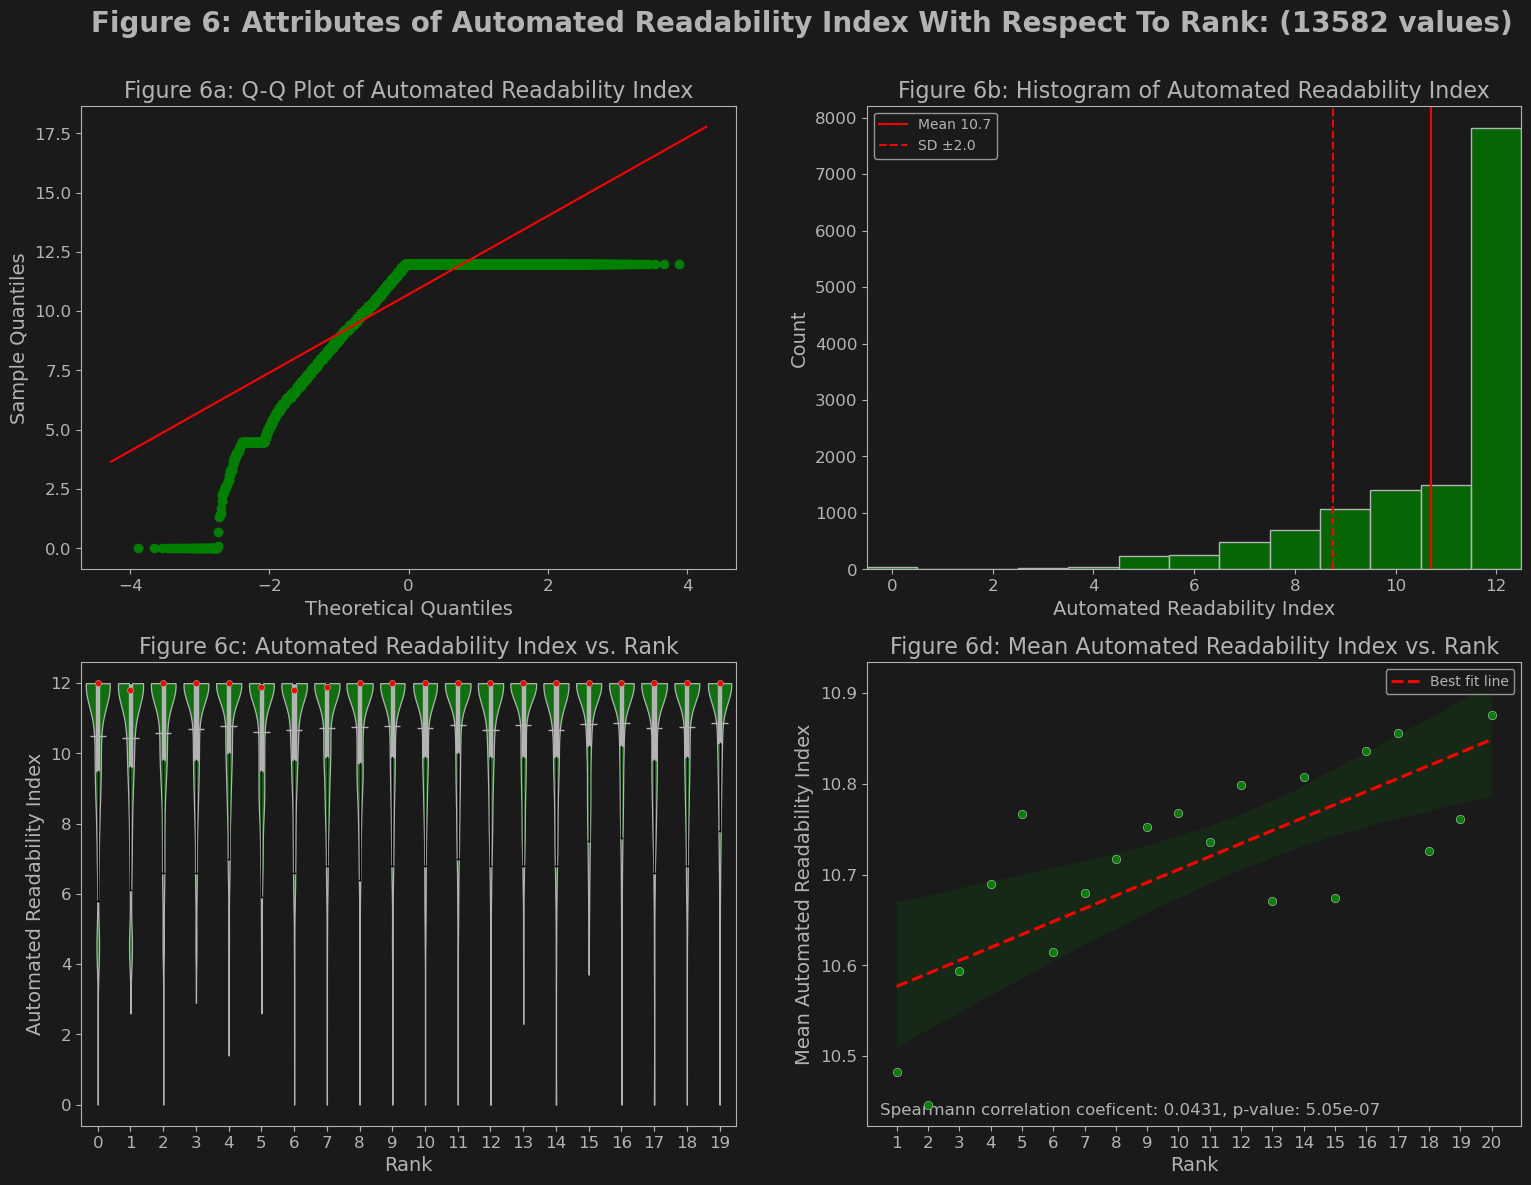

In [1573]:
col = 'Automated Readability Index'
multiplot(df, fig_name = 'Figure 6', col_y = col, sd=1, dark_mode = True)

In [1574]:
find_ai_in_range(df, col='Automated Readability Index', cut_min=6, cut_max= 11)

For Automated Readability Index below 6: 53 of 451, or 11.8% of have AI-CS > 50%
For Automated Readability Index above 6 and below 11: 307 of 4697, or 6.5% of have AI-CS > 50%
For Automated Readability Index above 11: 879 of 8434, or 10.4% of have AI-CS > 50%


In [1575]:
col = 'Automated Readability Index'
avg_aics_within_sd(df, col)

,sd,avg_aics
0,1,14.875793
1,2,14.879834
2,3,14.930563


In [1576]:
col = 'Automated Readability Index'
avg_aics_in_out_of_sd(df, col, sd=3)

(   avg_aics_within_3sd
 0            14.930563,
    avg_aics_outside_3sd
 0             22.845868)

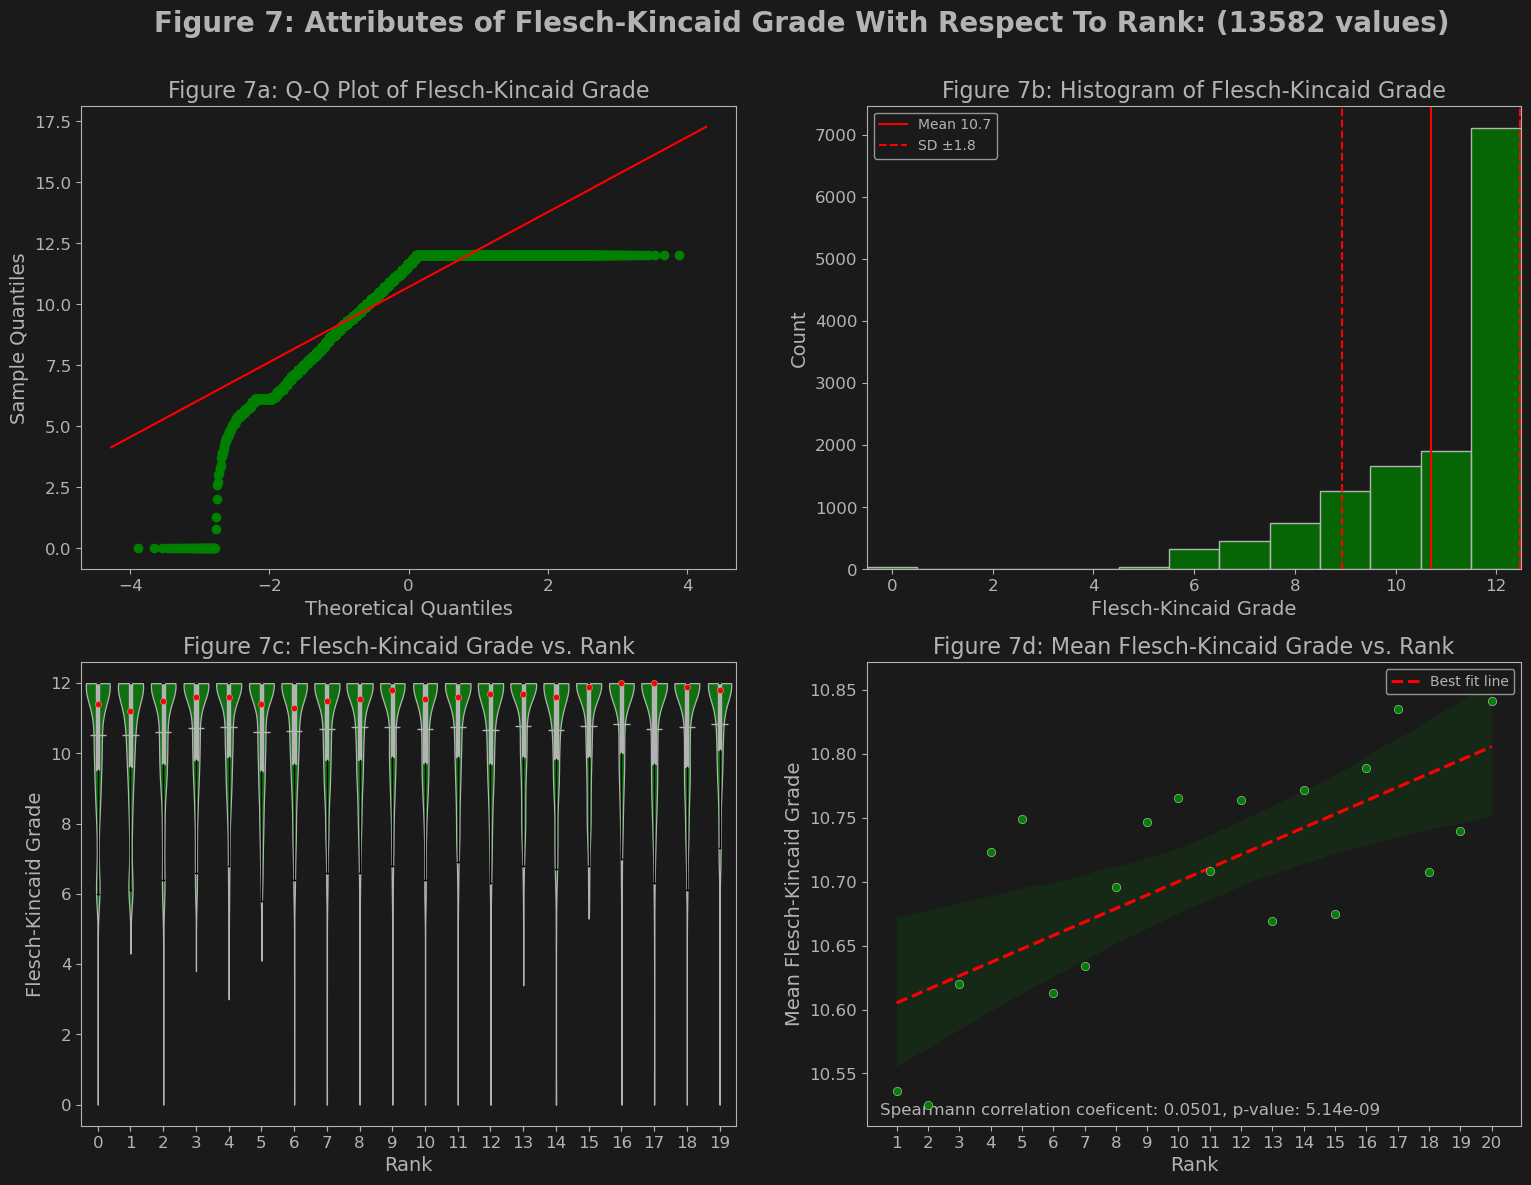

In [1577]:
multiplot(df, fig_name = 'Figure 7', col_y = 'Flesch-Kincaid Grade', sd=1, dark_mode = True)

In [1578]:
find_ai_in_range(df, col='Flesch-Kincaid Grade', cut_min=6, cut_max= 11)

For Flesch-Kincaid Grade below 6: 30 of 163, or 18.4% of have AI-CS > 50%
For Flesch-Kincaid Grade above 6 and below 11: 364 of 5530, or 6.6% of have AI-CS > 50%
For Flesch-Kincaid Grade above 11: 845 of 7889, or 10.7% of have AI-CS > 50%


In [1579]:
col='Flesch-Kincaid Grade'
avg_aics_within_sd(df, col)

,sd,avg_aics
0,1,14.969328
1,2,14.905456
2,3,15.015412


In [1580]:
col='Flesch-Kincaid Grade'
avg_aics_in_out_of_sd(df, col, sd=3)

(   avg_aics_within_3sd
 0            15.015412,
    avg_aics_outside_3sd
 0             25.421004)

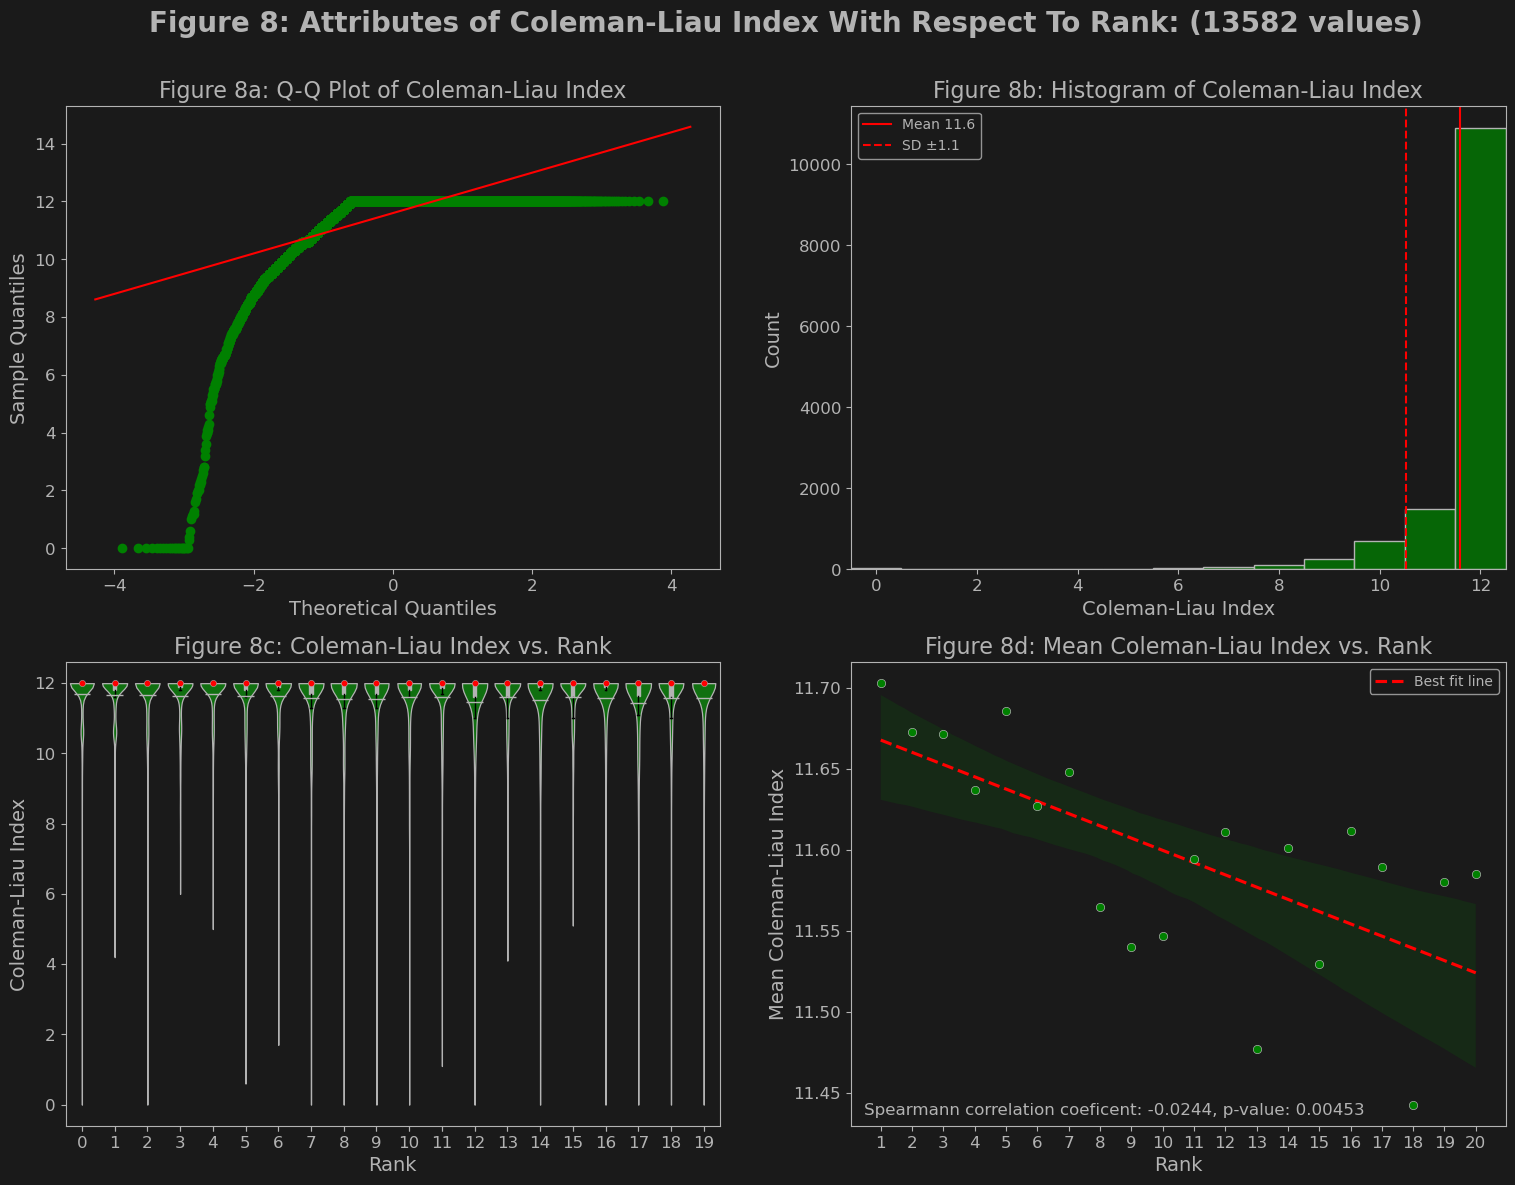

In [1581]:
multiplot(df, fig_name = 'Figure 8', col_y = 'Coleman-Liau Index', sd=1, dark_mode = True)

In [1582]:
col = 'Coleman-Liau Index'
find_ai_in_range(df, col=col, cut_min=8, cut_max= 11)

For Coleman-Liau Index below 8: 36 of 194, or 18.6% of have AI-CS > 50%
For Coleman-Liau Index above 8 and below 11: 158 of 1860, or 8.5% of have AI-CS > 50%
For Coleman-Liau Index above 11: 1045 of 11528, or 9.1% of have AI-CS > 50%


In [1583]:
col = 'Coleman-Liau Index'
avg_aics_within_sd(df, col)

,sd,avg_aics
0,1,14.923519
1,2,14.917986
2,3,14.952254


In [1584]:
col = 'Coleman-Liau Index'
avg_aics_in_out_of_sd(df, col, sd=3)

(   avg_aics_within_3sd
 0            14.952254,
    avg_aics_outside_3sd
 0             22.958842)

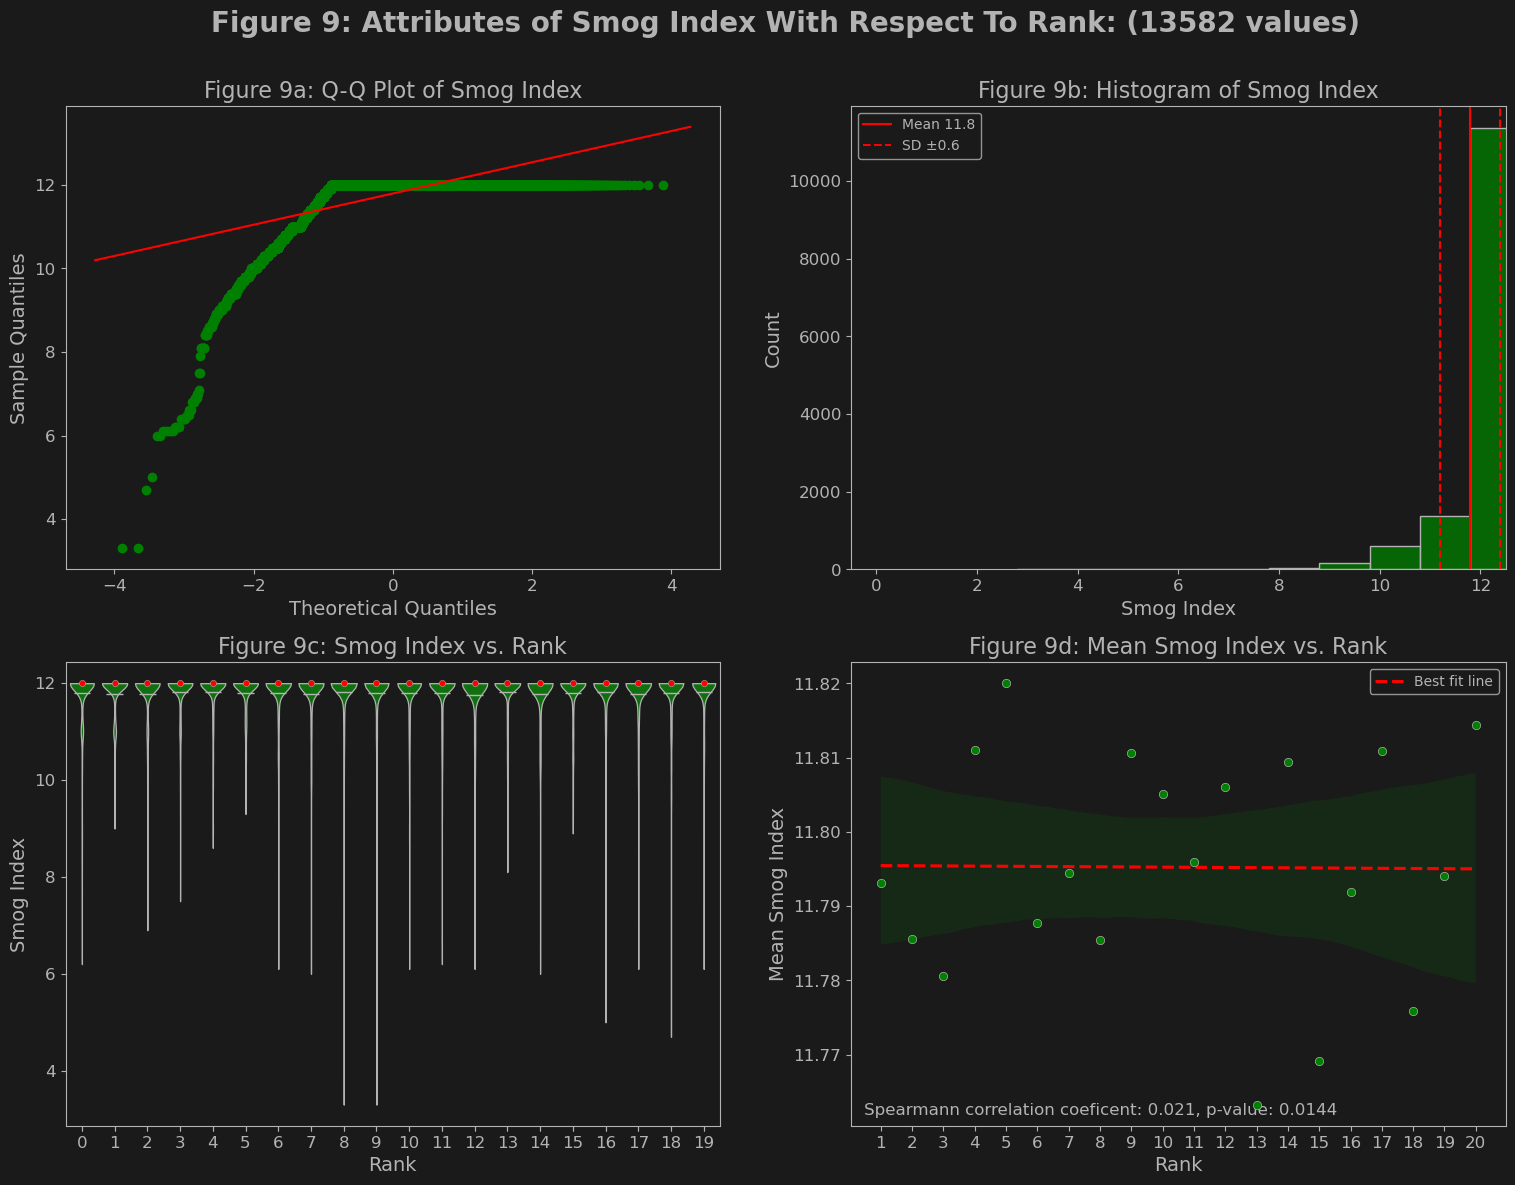

In [1585]:
col = 'Smog Index'
multiplot(df, fig_name = f'Figure 9', col_y = col, sd=1, dark_mode = True)

In [1586]:
col = 'Smog Index'
find_ai_in_range(df, col=col, cut_min=8, cut_max= 11)

For Smog Index below 8: 13 of 39, or 33.3% of have AI-CS > 50%
For Smog Index above 8 and below 11: 100 of 1220, or 8.2% of have AI-CS > 50%
For Smog Index above 11: 1126 of 12323, or 9.1% of have AI-CS > 50%


In [1587]:
col = 'Smog Index'
avg_aics_within_sd(df, col)

,sd,avg_aics
0,1,14.964169
1,2,14.969037
2,3,15.020352


In [1588]:
col = 'Smog Index'
avg_aics_in_out_of_sd(df, col, sd=5)

(   avg_aics_within_5sd
 0            15.031251,
    avg_aics_outside_5sd
 0              26.60775)

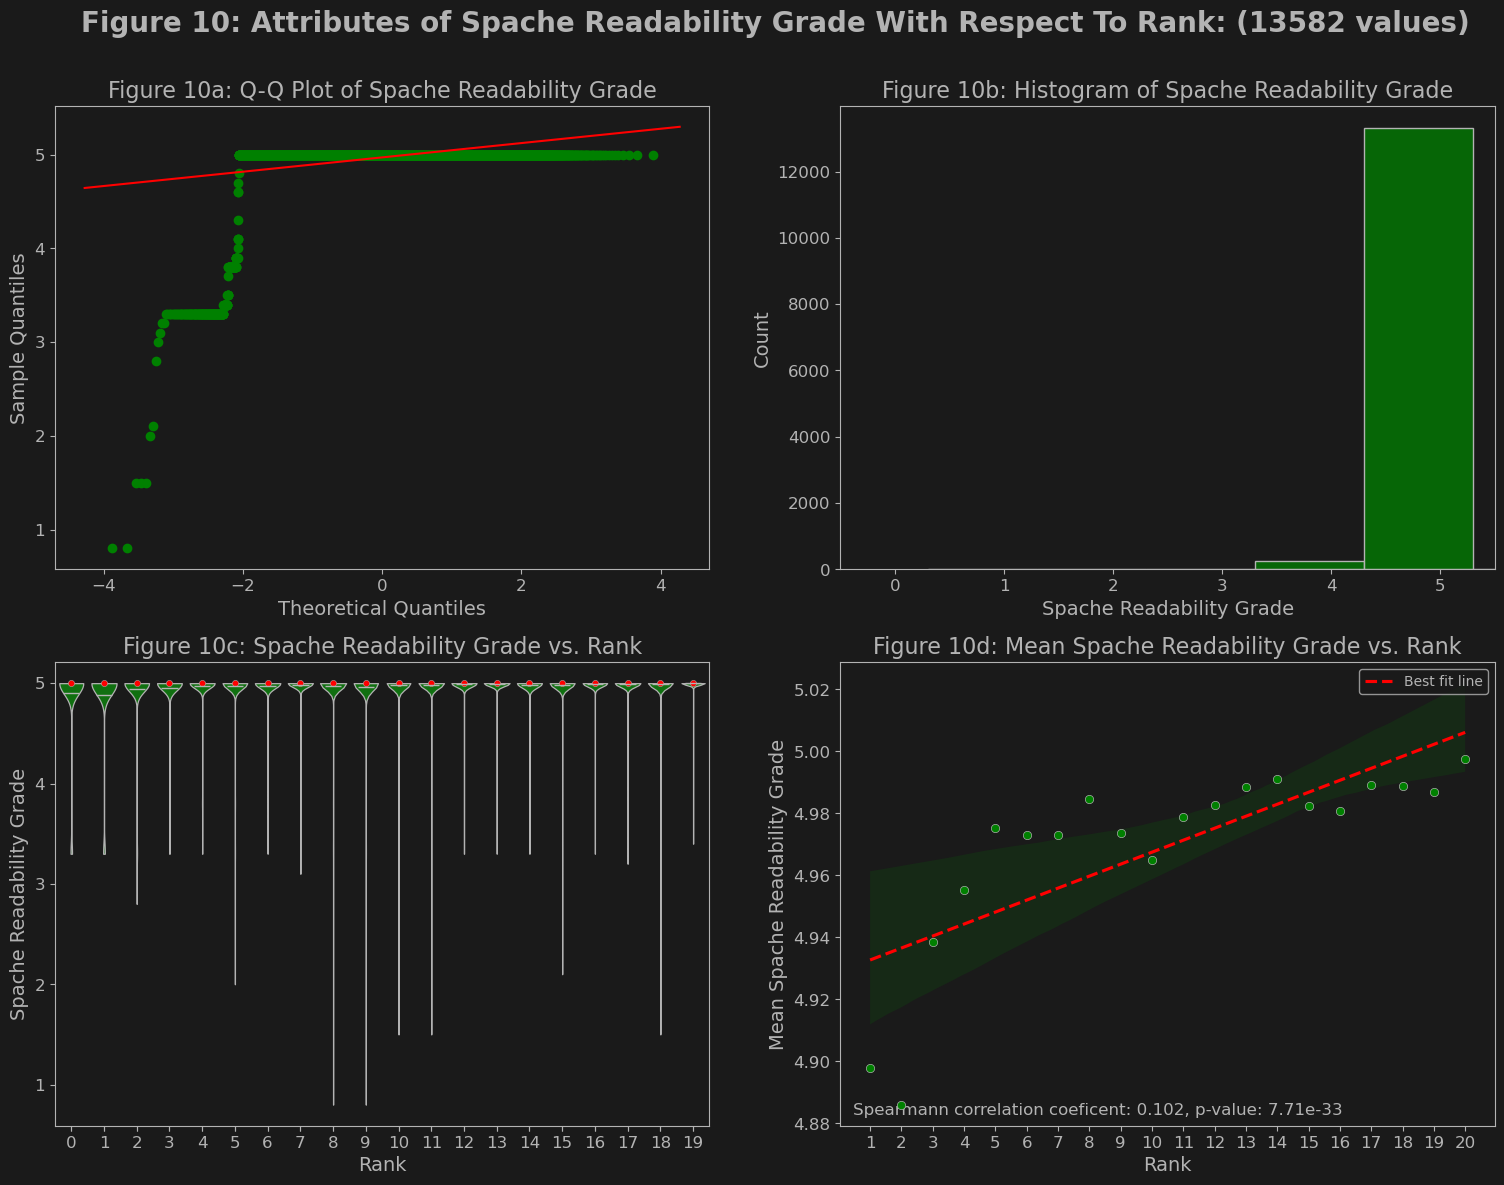

In [1589]:
col = 'Spache Readability Grade'
multiplot(df, fig_name = f'Figure 10', col_y = col, sd=0, dark_mode =True)

In [1590]:
col = 'Spache Readability Grade'
find_ai_in_range(df, col=col, cut_min=2.9, cut_max= 4.9)

For Spache Readability Grade below 2.9: 4 of 8, or 50.0% of have AI-CS > 50%
For Spache Readability Grade above 2.9 and below 4.9: 20 of 258, or 7.8% of have AI-CS > 50%
For Spache Readability Grade above 4.9: 1215 of 13316, or 9.1% of have AI-CS > 50%


In [1591]:
col = 'Spache Readability Grade'
avg_aics_within_sd(df, col)

,sd,avg_aics
0,1,14.970603
1,2,14.974770
2,3,14.973647


In [1592]:
col = 'Spache Readability Grade'
avg_aics_in_out_of_sd(df, col, sd=3)

(   avg_aics_within_3sd
 0            14.973647,
    avg_aics_outside_3sd
 0              21.25346)

In [1593]:
def plot (df, col_1, col_2):

        

    # Plot col_1 vs col_2 as an XY scatter plot
    plt.scatter(df[col_1], df[col_2])


    # Set axis labels and plot title
    plt.xlabel(col_1)
    plt.ylabel(col_2)
    plt.title(f'XY Scatter Plot of {col_1} vs {col_2}')

    # Show the plot
    plt.show()

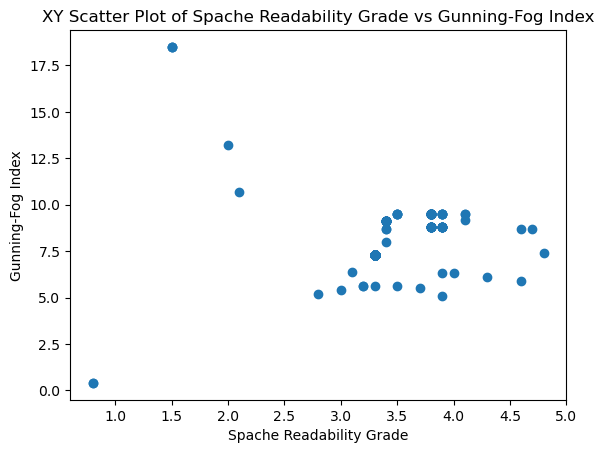

266

In [1594]:
col_1 = 'Spache Readability Grade'
col_2 = 'Gunning-Fog Index'
df_mod = df[df[col_1] < 5]
plot (df_mod, col_1, col_2)
len(df_mod)


In [1595]:
def plot(df, col_1, col_2):

    # Load data into a pandas DataFrame
    #df = pd.read_csv('data.csv')

    # Plot col_1 vs col_2 as an XY scatter plot
    plt.scatter(df[col_1], df[col_2])

    # Calculate the best-fit line using linear regression
    slope, intercept, r_value, p_value, std_err = st.linregress(df[col_1], df[col_2])
    line = slope * df[col_1] + intercept

    # Plot the best-fit line
    plt.plot(df[col_1], line, color='red')

    # Set axis labels and plot title
    plt.xlabel(col_1)
    plt.ylabel(col_2)
    plt.title(f'XY Scatter Plot of {col_1} vs {col_2}')

    # Show the plot
    plt.show()

In [1596]:
df.columns

Index(['rank', 'Flesch Reading Ease Index', 'Gunning-Fog Index',
       'FORCAST Grade', 'Dale-Chall Index', 'Powers-Sumner-Kearl Index',
       'Automated Readability Index', 'Flesch-Kincaid Grade',
       'Coleman-Liau Index', 'Smog Index', 'Spache Readability Grade',
       'word_count', 'aics', 'hcs'],
      dtype='object')

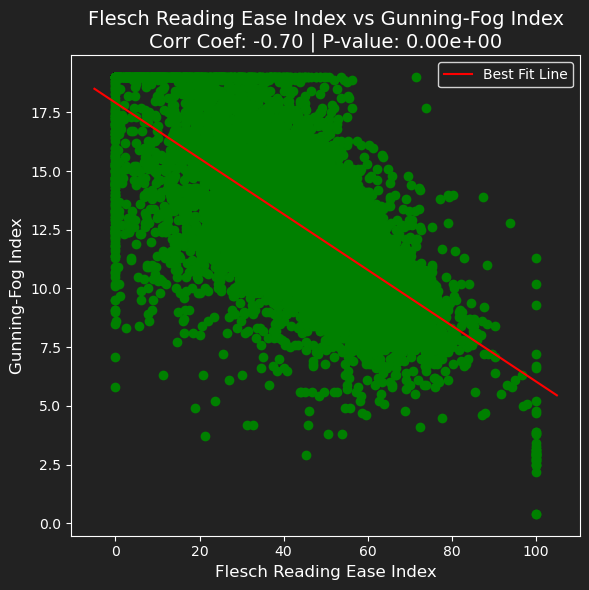

In [1597]:
col_x = 'Flesch Reading Ease Index'
col_y = 'Gunning-Fog Index'
single_plot(df, col_x, col_y)

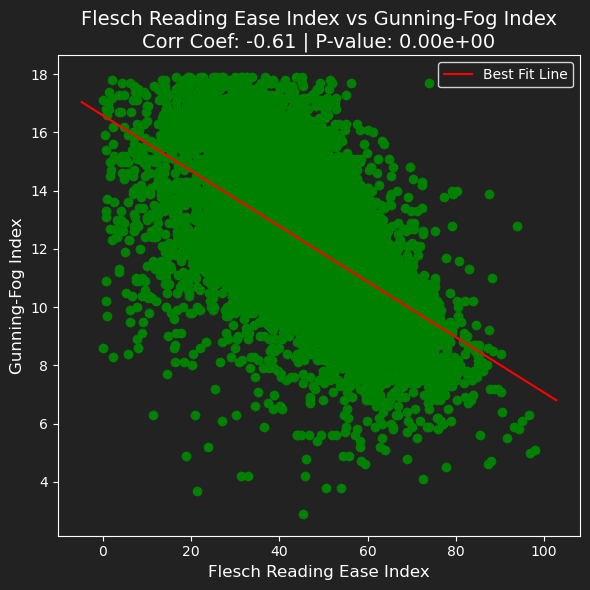

In [1598]:
col_x = 'Flesch Reading Ease Index'
col_y = 'Gunning-Fog Index'
x = df[(df[col_x] > 0) & (df[col_x] < 100)]
x = x[x[col_y] < 18]
single_plot(x, col_x, col_y)

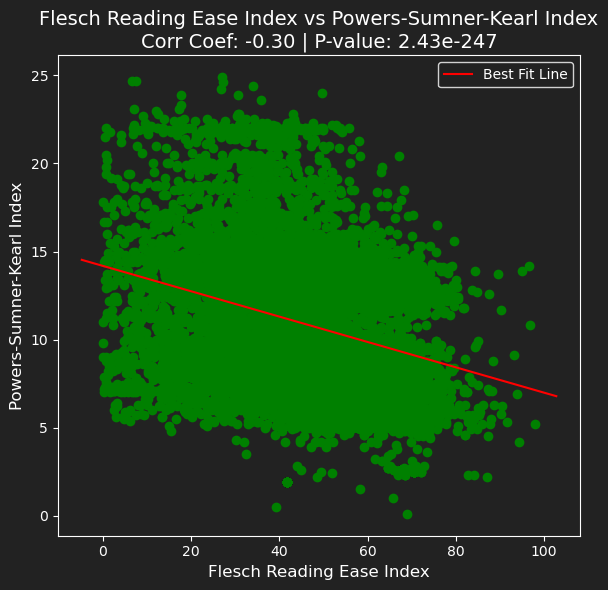

In [1599]:
col_x = 'Flesch Reading Ease Index'
col_y = 'Powers-Sumner-Kearl Index'
x = df[(df[col_x] > 0) & (df[col_x] < 100)]
x = x[(x[col_y] > 0.0) & (x[col_y] < 25)]
single_plot(x, col_x, col_y)

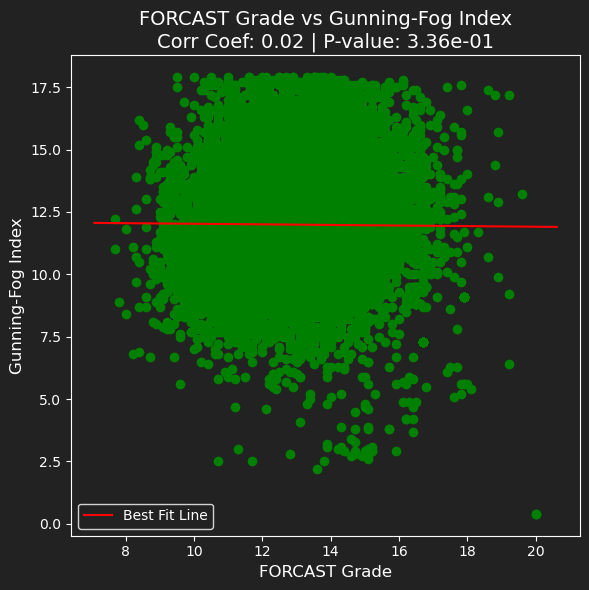

In [1600]:
col_x = 'FORCAST Grade'
col_y = 'Gunning-Fog Index'
x = df[(df[col_x] > 0) & (df[col_x] < 100)]
x = x[x[col_y] < 18]
single_plot(x, col_x, col_y)

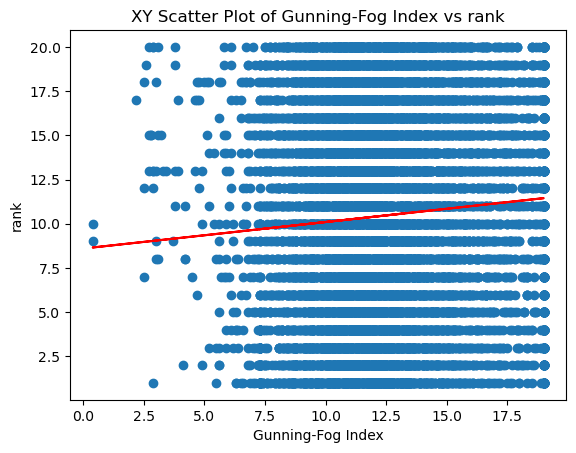

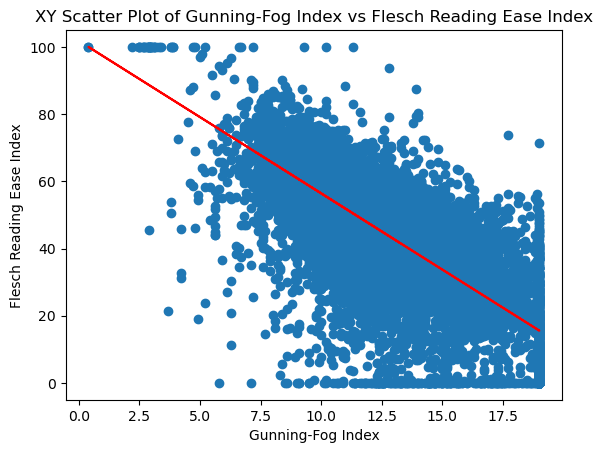

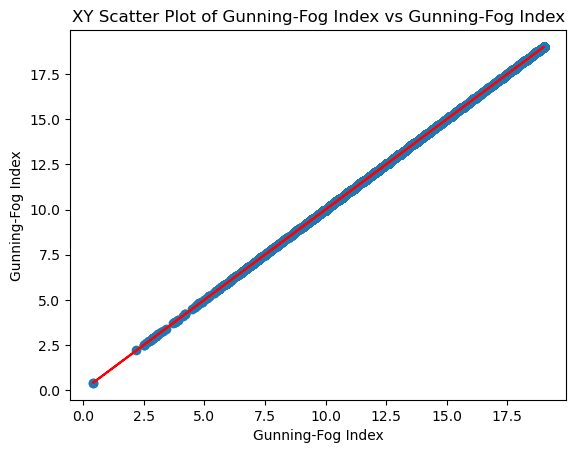

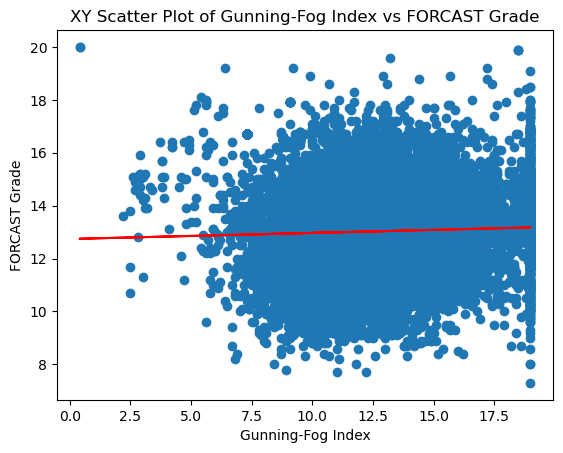

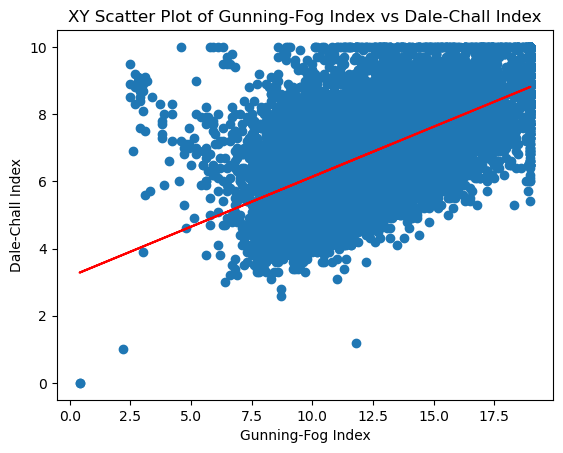

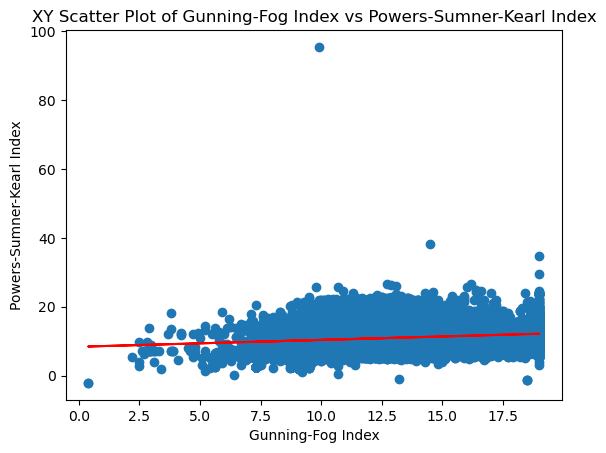

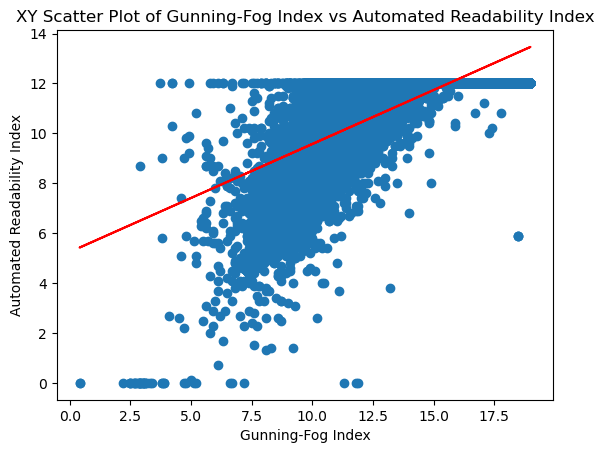

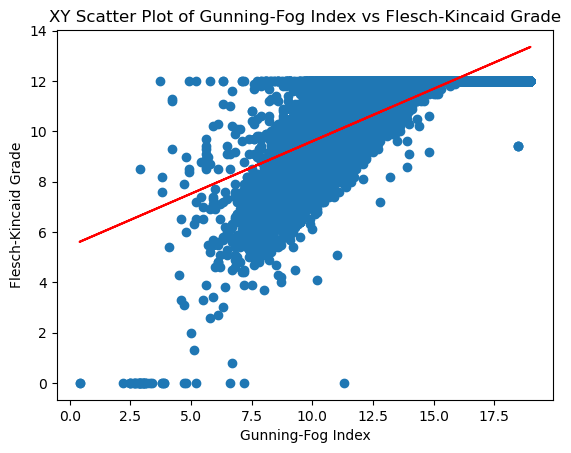

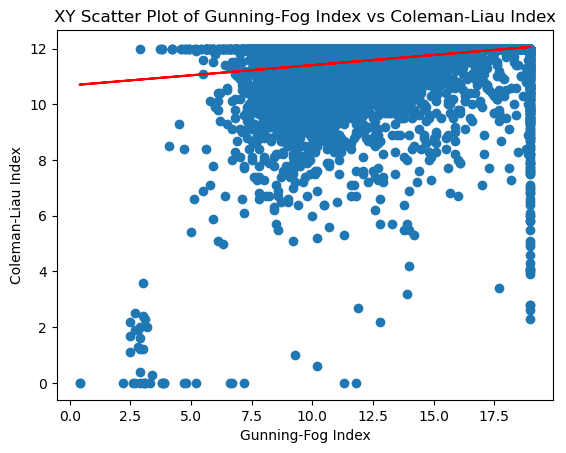

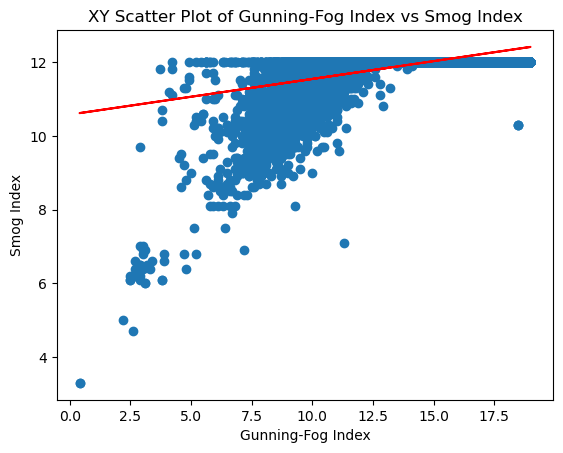

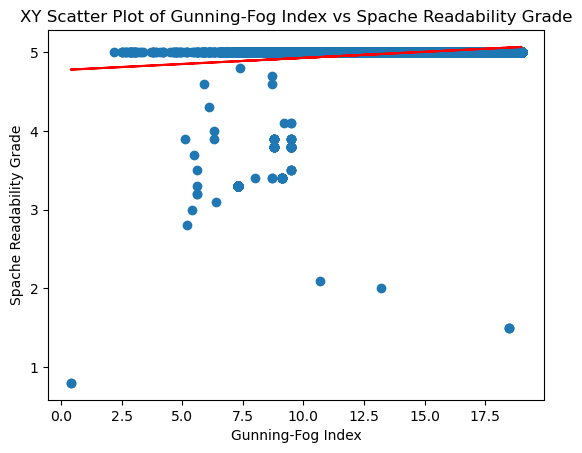

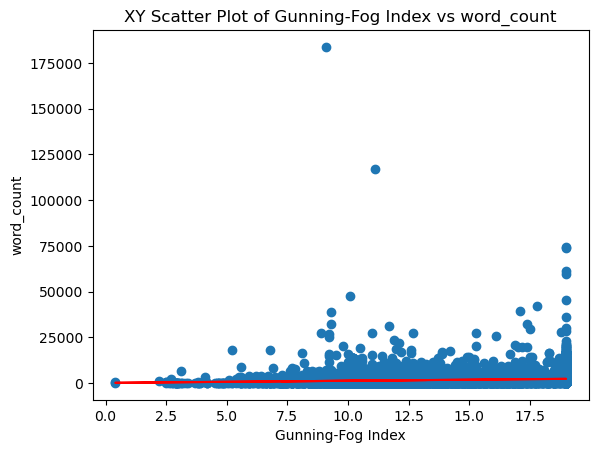

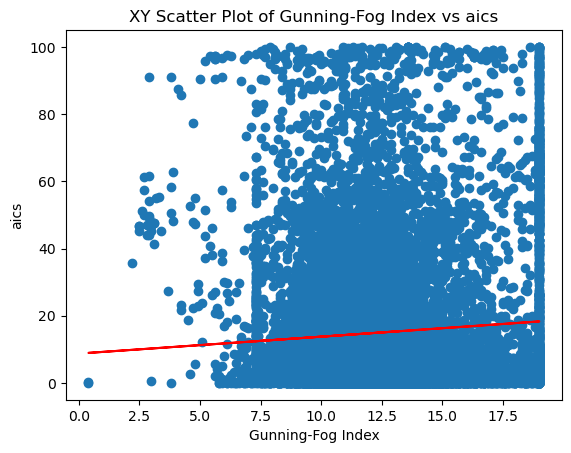

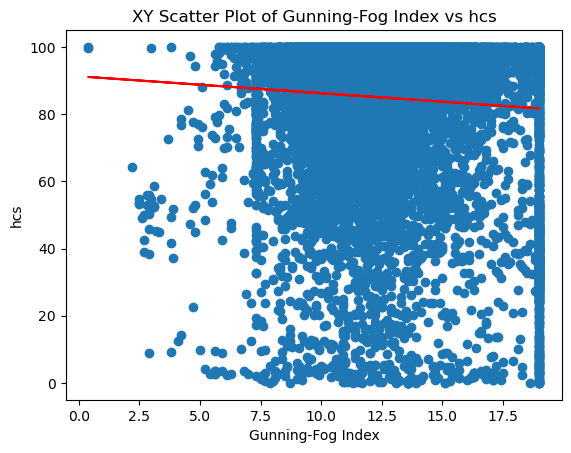

In [1601]:
col_1 = 'Gunning-Fog Index'
for col_2 in df.columns:
    plot(df, col_1, col_2)